In [ ]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/IS_Assignment4/RML2016.10b.tar.bz2', '/content/drive/MyDrive/IS_Assignment4/Data_Extracted/')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pickle

In [3]:
file = open('/content/drive/MyDrive/IS_Assignment4/Data_Extracted/RML2016.10b.dat','rb')
Xd = pickle.load(file, encoding = 'bytes')
# get all mods and snrs from keys which are in form of (mod , snr)
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        # append different samples to X
        X.append(Xd[(mod,snr)])
        # add labels to all X values in previous step
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

In [4]:
del Xd

In [ ]:
print(mods)

[b'8PSK', b'AM-DSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']


In [5]:
#utility function for one hot
def mods_to_map():
  mods_map = {}
  for i in range(len(mods)):
    mods_map[mods[i]] = i
  
  return mods_map

In [ ]:
mods_to_map()

{b'8PSK': 0,
 b'AM-DSB': 1,
 b'BPSK': 2,
 b'CPFSK': 3,
 b'GFSK': 4,
 b'PAM4': 5,
 b'QAM16': 6,
 b'QAM64': 7,
 b'QPSK': 8,
 b'WBFM': 9}

In [ ]:
print(X.shape)

(1200000, 2, 128)


In [6]:
def get_raw_features():
  return X

In [7]:
def get_dev_features(): # derivative features
  grad_channel_one = np.gradient(X[: , 0] , axis=1).reshape(X.shape[0] , 1 , X.shape[2])
  grad_channel_two = np.gradient(X[: , 1] , axis=1).reshape(X.shape[0] , 1 , X.shape[2])
  return np.hstack(( grad_channel_one , grad_channel_two ))

In [ ]:
print(get_dev_features().shape)

(1200000, 2, 128)


In [8]:
def get_integral_features(): # get integral features
  integral_channel_one = np.cumsum(X[: , 0] , axis=1).reshape(X.shape[0] , 1 , X.shape[2])
  integral_channel_two = np.cumsum(X[: , 1] , axis=1).reshape(X.shape[0] , 1 , X.shape[2])
  return np.hstack(( integral_channel_one , integral_channel_two ))

In [ ]:
print(get_integral_features().shape)

(1200000, 2, 128)


In [9]:
def get_more_channels(): # all features 
  return np.hstack(( X , get_dev_features() , get_integral_features() ))

In [ ]:
print(get_more_channels().shape)

(1200000, 6, 128)


In [10]:
def one_hot(data_Y):

  data_Y = list(data_Y)

  mods_map = mods_to_map()
  
  one_hot_arr = np.zeros(( len(data_Y) , len(mods_map) ))

  for i in range (len(data_Y)):
    one_hot_arr[ i , mods_map[data_Y[i]] ] = 1
    
  return one_hot_arr

In [11]:
# data_X is array
def data_split(data_X , Evaluate = False):
  np.random.seed(0)
  data_no = data_X.shape[0]

  # split train by 70%
  train_no = int(data_no * 0.7)
  train_idx = np.random.choice(range(0 , data_no) , size=train_no , replace=False)
  
  # remaining index for test
  test_idx = list( set(range(0 , data_no)) - set(train_idx) )

  
  test_X = data_X[test_idx]
  test_Y = one_hot(map( lambda x: lbl[x][0] , test_idx))

  # split train to train(95%) and val(5%)
  val_no = int(train_no * 0.05)
  val_idx = np.random.choice(train_idx , size=val_no , replace=False)
  train_idx = list( set(train_idx) - set(val_idx) )

  train_X = data_X[train_idx]
  train_Y = one_hot(map( lambda x: lbl[x][0] , train_idx))

  val_X = data_X[val_idx]
  val_Y = one_hot(map( lambda x: lbl[x][0] , val_idx))


  if Evaluate == True :
    return test_X , test_Y , test_idx


  return train_X , train_Y , val_X , val_Y , test_X , test_Y


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
def Decision_Tree_Model(data_X):
  train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(data_X)

  train_X = train_X.reshape(train_X.shape[0] , train_X.shape[1] * train_X.shape[2])
  train_Y = np.argwhere(train_Y == 1)[: , 1]
  val_X = val_X.reshape(val_X.shape[0] , val_X.shape[1] * val_X.shape[2])
  val_Y = np.argwhere(val_Y == 1)[: , 1]
  test_X = test_X.reshape(test_X.shape[0] , test_X.shape[1] * test_X.shape[2])
  test_Y = np.argwhere(test_Y == 1)[: , 1]
  # tune max depth
  #Max_Depth = np.arange(2,10)
  criteria = ['gini' , 'entropy']
  Best_Model = DecisionTreeClassifier()
  Best_Val_acc = 0
  for i in criteria:
    print('criterion = '+ str(i))
    decision_tree_model = DecisionTreeClassifier(random_state = 0 , criterion=i)
    decision_tree_model.fit(train_X , train_Y)
    val_predict = decision_tree_model.predict(val_X)
    temp_acc = accuracy_score(val_Y , val_predict)
    print('val accuracy: ' + str(temp_acc))
    if temp_acc > Best_Val_acc:
      Best_Val_acc = temp_acc
      Best_Model = decision_tree_model
      

  print('-----------------Best Model--------------------------')
  train_predict = Best_Model.predict(train_X)
  train_acc = accuracy_score(train_Y , train_predict)
  print('train accuracy: ' + str(train_acc))

  val_predict = Best_Model.predict(val_X)
  val_acc = accuracy_score(val_Y , val_predict)
  print('validation accuracy: ' + str(val_acc))


  test_predict = Best_Model.predict(test_X)
  test_acc = accuracy_score(test_Y , test_predict)
  print('test accuracy: ' + str(test_acc))

  return Best_Model   

In [ ]:
Best_Model = Decision_Tree_Model(X)

criterion = gini
val accuracy: 0.30883333333333335
criterion = entropy
val accuracy: 0.30938095238095237
-----------------Best Model--------------------------
train accuracy: 1.0
validation accuracy: 0.30938095238095237
test accuracy: 0.31218055555555557


In [ ]:
pickle.dump(Best_Model , open('/content/drive/MyDrive/IS_Assignment4/Models/Decision_Tree_Raw.sav' , 'wb'))

In [ ]:
Best_Model = Decision_Tree_Model(get_dev_features())

criterion = gini
val accuracy: 0.22933333333333333
criterion = entropy
val accuracy: 0.2360952380952381
-----------------Best Model--------------------------
train accuracy: 1.0
validation accuracy: 0.2360952380952381
test accuracy: 0.23540555555555556


In [ ]:
pickle.dump(Best_Model , open('/content/drive/MyDrive/IS_Assignment4/Models/Decision_Tree_Dev.sav' , 'wb'))

In [ ]:
Best_Model = Decision_Tree_Model(get_integral_features())

criterion = gini
val accuracy: 0.3207380952380952
criterion = entropy
val accuracy: 0.31695238095238093
-----------------Best Model--------------------------
train accuracy: 1.0
validation accuracy: 0.3207380952380952
test accuracy: 0.3227111111111111


In [ ]:
pickle.dump(Best_Model , open('/content/drive/MyDrive/IS_Assignment4/Models/Decision_Tree_Int.sav' , 'wb'))

In [ ]:
Best_Model = Decision_Tree_Model(get_more_channels())

criterion = gini
val accuracy: 0.31876190476190475
criterion = entropy
val accuracy: 0.3130952380952381
-----------------Best Model--------------------------
train accuracy: 1.0
validation accuracy: 0.31876190476190475
test accuracy: 0.3189722222222222


In [ ]:
pickle.dump(Best_Model , open('/content/drive/MyDrive/IS_Assignment4/Models/Decision_Tree_channels.sav' , 'wb'))

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def Random_Forest_Model(data_X):
  train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(data_X)

  train_X = train_X.reshape(train_X.shape[0] , train_X.shape[1] * train_X.shape[2])
  train_Y = np.argwhere(train_Y == 1)[: , 1]
  val_X = val_X.reshape(val_X.shape[0] , val_X.shape[1] * val_X.shape[2])
  val_Y = np.argwhere(val_Y == 1)[: , 1]
  test_X = test_X.reshape(test_X.shape[0] , test_X.shape[1] * test_X.shape[2])
  test_Y = np.argwhere(test_Y == 1)[: , 1]
  # tune max depth
  Max_Depth = [20] #, 25]
  Best_Model = RandomForestClassifier()
  Best_Val_acc = 0
  for i in Max_Depth:
    print('Max Depth = '+ str(i))
    random_forest_model = RandomForestClassifier(random_state = 0 , max_depth = i)
    random_forest_model.fit(train_X , train_Y)
    val_predict = random_forest_model.predict(val_X)
    temp_acc = accuracy_score(val_Y , val_predict)
    print('val accuracy: ' + str(temp_acc))
    if temp_acc > Best_Val_acc:
      Best_Val_acc = temp_acc
      Best_Model = random_forest_model

  print('-----------------Best Model--------------------------')
  train_predict = Best_Model.predict(train_X)
  train_acc = accuracy_score(train_Y , train_predict)
  print('train accuracy: ' + str(train_acc))

  val_predict = Best_Model.predict(val_X)
  val_acc = accuracy_score(val_Y , val_predict)
  print('validation accuracy: ' + str(val_acc))

  test_predict = Best_Model.predict(test_X)
  test_acc = accuracy_score(test_Y , test_predict)
  print('test accuracy: ' + str(test_acc))

  return Best_Model   

In [ ]:
Best_Model = Random_Forest_Model(X)

Max Depth = 20
val accuracy: 0.4332142857142857
-----------------Best Model--------------------------
train accuracy: 0.9776942355889724
validation accuracy: 0.4332142857142857
test accuracy: 0.4365833333333333


In [ ]:
pickle.dump(Best_Model , open('/content/drive/MyDrive/IS_Assignment4/Models/Random_Forest_Raw.sav' , 'wb'))

In [ ]:
Best_Model = Random_Forest_Model(get_dev_features())

Max Depth = 20
val accuracy: 0.3068571428571429
-----------------Best Model--------------------------
train accuracy: 0.9845225563909774
validation accuracy: 0.3068571428571429
test accuracy: 0.30719166666666664


In [ ]:
pickle.dump(Best_Model , open('/content/drive/MyDrive/IS_Assignment4/Models/Random_Forest_Dev.sav' , 'wb'))

In [ ]:
Best_Model = Random_Forest_Model(get_integral_features())

Max Depth = 20
val accuracy: 0.3752142857142857
-----------------Best Model--------------------------
train accuracy: 0.4967355889724311
validation accuracy: 0.3752142857142857
test accuracy: 0.3740472222222222


In [ ]:
pickle.dump(Best_Model , open('/content/drive/MyDrive/IS_Assignment4/Models/Random_Forest_Int.sav' , 'wb'))

In [ ]:
Best_Model = Random_Forest_Model(get_more_channels())

Max Depth = 20
val accuracy: 0.3785
-----------------Best Model--------------------------
train accuracy: 0.5565551378446115
validation accuracy: 0.3785
test accuracy: 0.38029444444444443


In [ ]:
pickle.dump(Best_Model , open('/content/drive/MyDrive/IS_Assignment4/Models/Random_Forest_channels.sav' , 'wb'))

# Evaluation

In [12]:
import matplotlib.pyplot as plt
import itertools

In [13]:
def plot_conf_mat(conf_mat , title = '' , cmap = plt.cm.Reds):
  dots_per_inch  = 100
  plt.figure(figsize=(600 / dots_per_inch , 600 / dots_per_inch) , dpi=dots_per_inch)
  plt.imshow(conf_mat , interpolation='nearest' , cmap=cmap)
  plt.title(title)

  tick_marks = np.arange(len(mods))

  plt.xticks(tick_marks , mods , rotation = 45) # for rows
  plt.yticks(tick_marks , mods) # for columns

  threshold = conf_mat.max() / 2

  for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
    plt.text(j, i, str( int(conf_mat[i, j]) ),horizontalalignment="center",color= "white" if conf_mat[i , j] > threshold  else "black" )

  plt.tight_layout()
  plt.ylabel('True Values')
  plt.xlabel('Predicted values')
  plt.show()

In [14]:
def Eval_SNR(data_X , model , Neural_Net = False):
  test_X , test_Y , test_idx = data_split(data_X , Evaluate=True)
  test_X = test_X.reshape(test_X.shape[0] , test_X.shape[1] * test_X.shape[2])
  test_Y = np.argwhere(test_Y == 1)[: , 1]

  # get SNR of test data
  test_SNRs = list( map(lambda x : lbl[x][1] , test_idx) )

  # map holds accuracies for each SNR
  accs = {}

  for snr in snrs:
    # get test data for a specific SNR
    test_X_snr = test_X[np.where(np.array(test_SNRs) == snr)]
    test_Y_snr = test_Y[np.where(np.array(test_SNRs) == snr)]

    # predicted values for test
    test_predict = model.predict(test_X_snr)

    # create confusion matrix of shape (10 , 10)
    conf_mat = np.zeros((len(mods) , len(mods)))
    
    # fill confusion matrix in form (true , predicted)
    for i in range(test_X_snr.shape[0]):
      if Neural_Net == True:
        conf_mat[test_Y_snr[i] , np.argmax(np.array(test_predict[i])) ] += 1
      else:
        conf_mat[test_Y_snr[i] , test_predict[i] ] += 1

    
    plot_conf_mat(conf_mat , title = 'At SNR = ' + str(snr))

    # calculate accuracy
    all_true_data = np.sum(np.diag(conf_mat))
    all_data = np.sum(conf_mat)

    accs[snr] = (1.0 * all_true_data) / all_data


  # create confusion matrix of shape (10 , 10)
  conf_mat = np.zeros((len(mods) , len(mods)))

  test_predict = model.predict(test_X)
  for i in range(test_X.shape[0]):
    if Neural_Net == True:
      conf_mat[test_Y[i] , np.argmax(np.array(test_predict[i])) ] += 1
    else:
      conf_mat[test_Y[i] , test_predict[i] ] += 1

  plot_conf_mat(conf_mat , title = 'Overall Confusion Matrix')
  
  plt.plot(snrs , list(map(lambda x:accs[x] , snrs )))
  plt.xlabel('SNR')
  plt.ylabel('ACCURACY')
  plt.show()

  print('----------------Accuracies for SNRS-------------------')
  print(accs)
  return accs

In [15]:
all_models_path = '/content/drive/MyDrive/IS_Assignment4/Models'

## Logistic Regression

In [17]:
modelfile = open(all_models_path +  '/logReg_raw.sav','rb')
model_loaded = pickle.load(modelfile)

In [18]:
accs = Eval_SNR(X , model_loaded)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
print('Accuracy at SNR = 0 : ' + str(accs[0]))
print('Overall Accuracy : ' +str(sum(accs.values()) / len(snrs) ))

Accuracy at SNR = 0 : 0.18022805269567144
Overall Accuracy : 0.16001557770194735


## Decision Tree

In [ ]:
modelfile = open(all_models_path + '/Decision_Tree_Int.sav','rb')
model_loaded = pickle.load(modelfile)

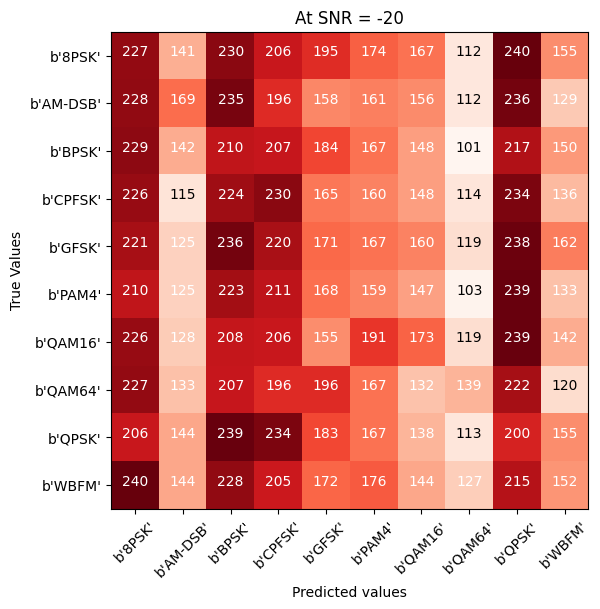

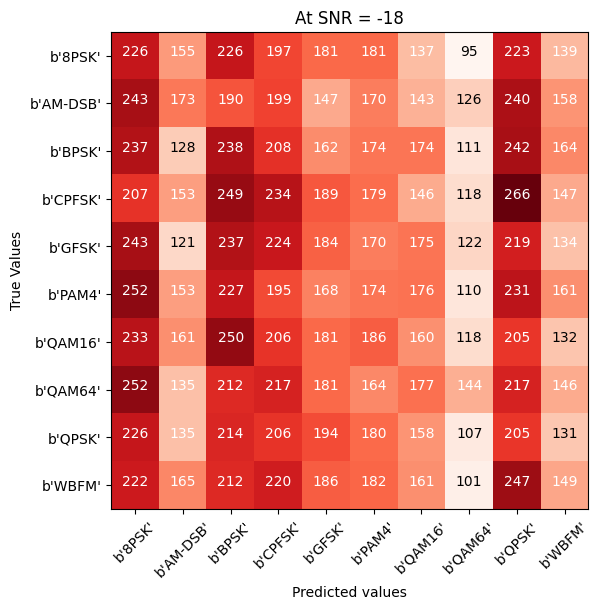

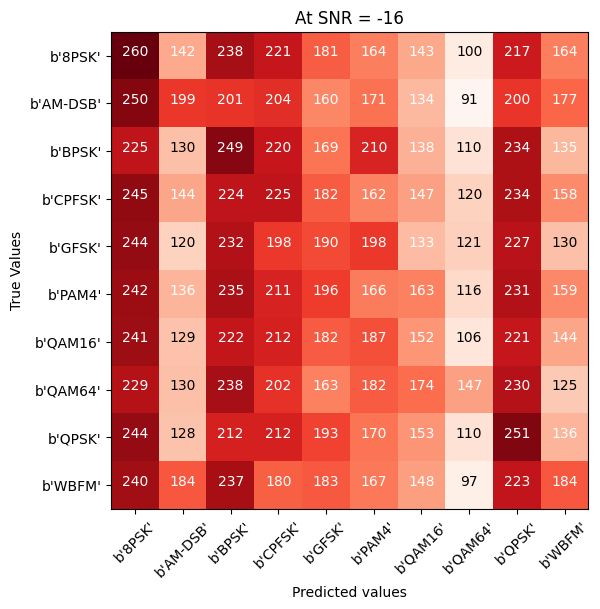

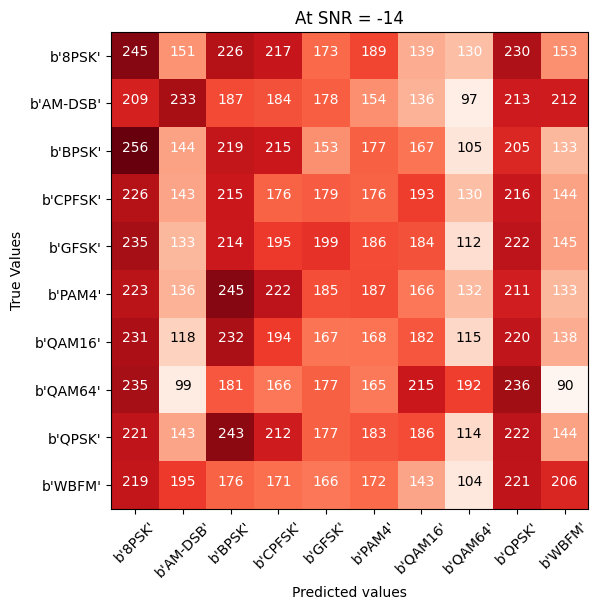

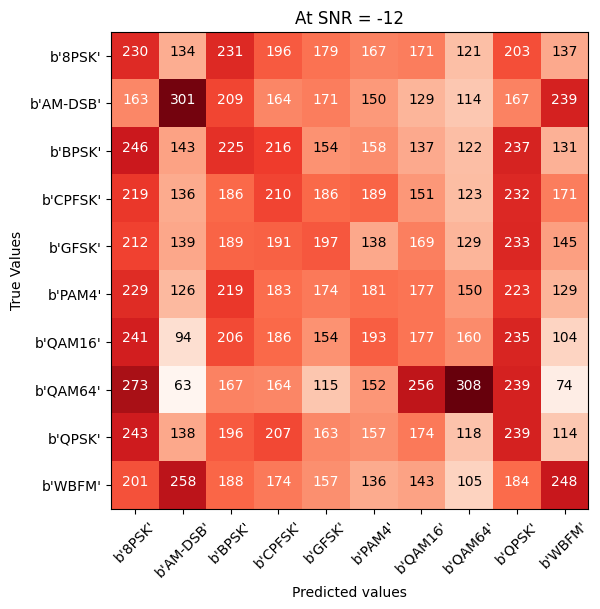

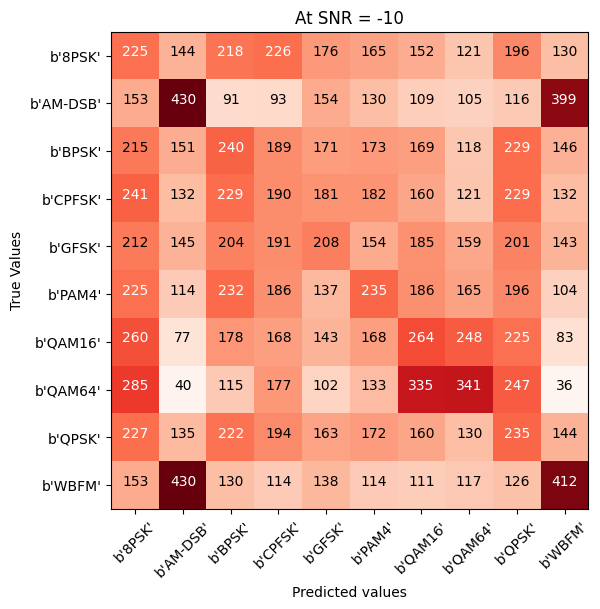

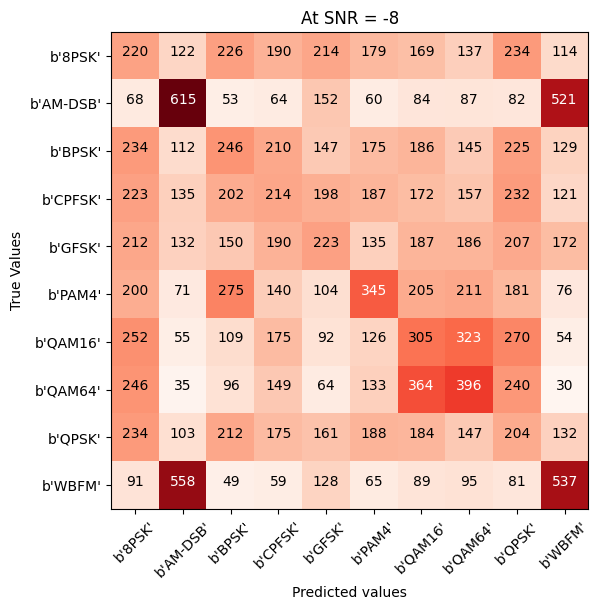

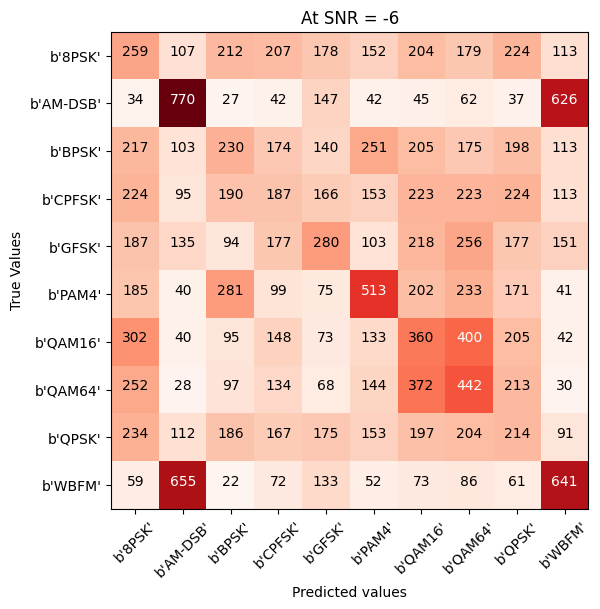

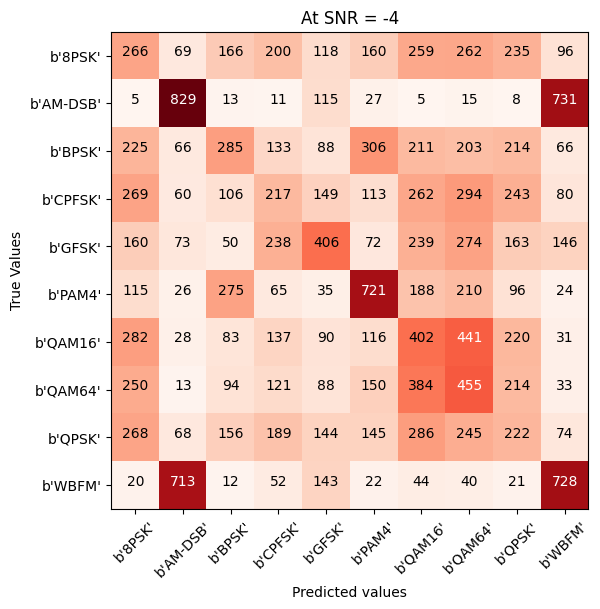

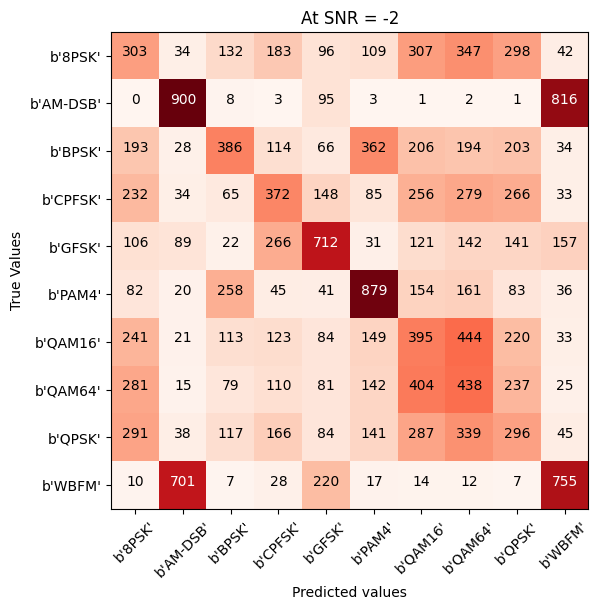

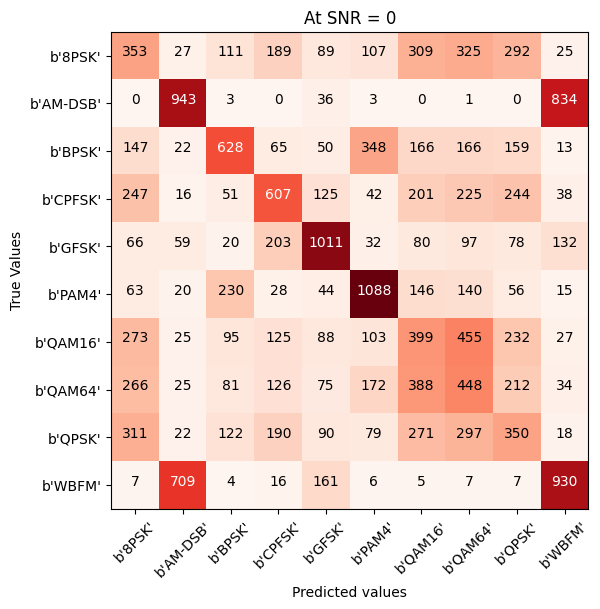

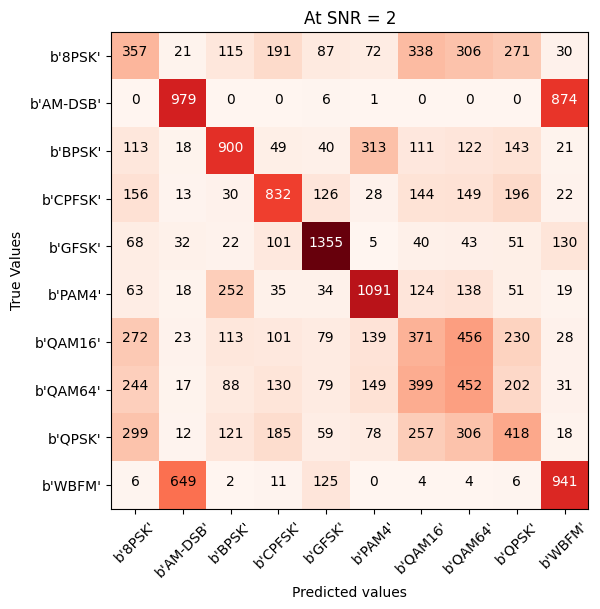

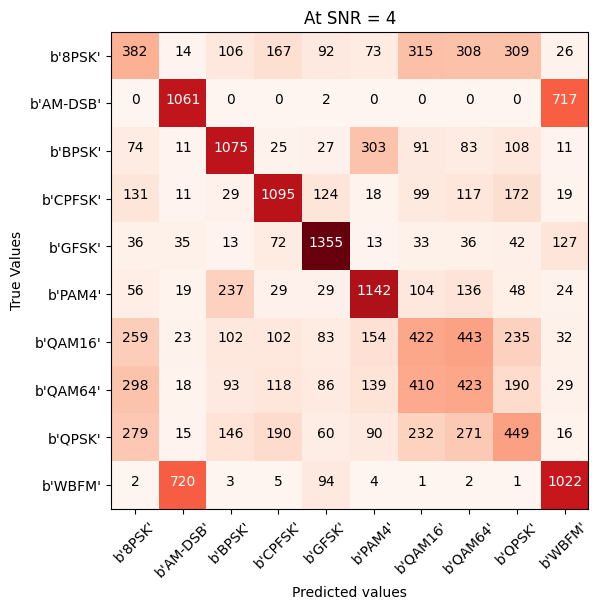

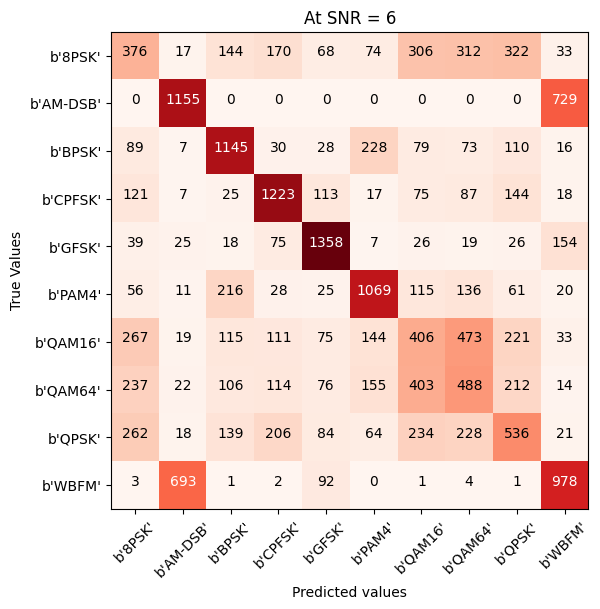

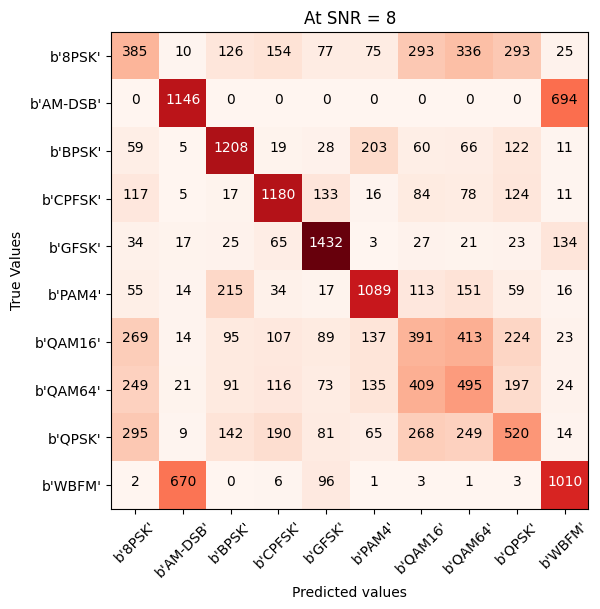

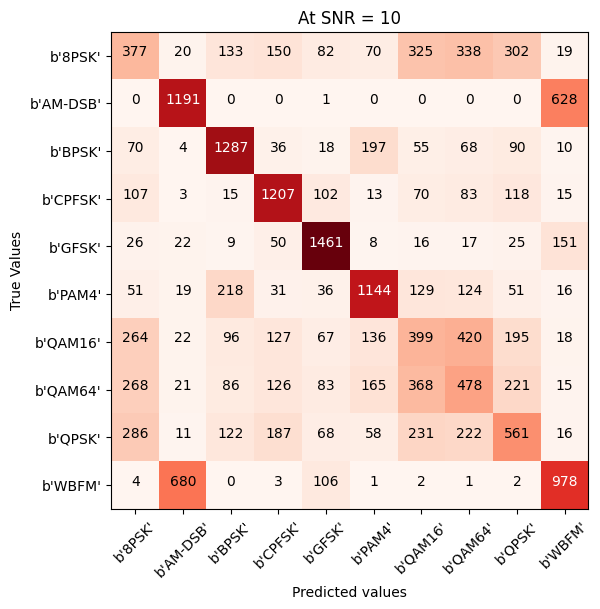

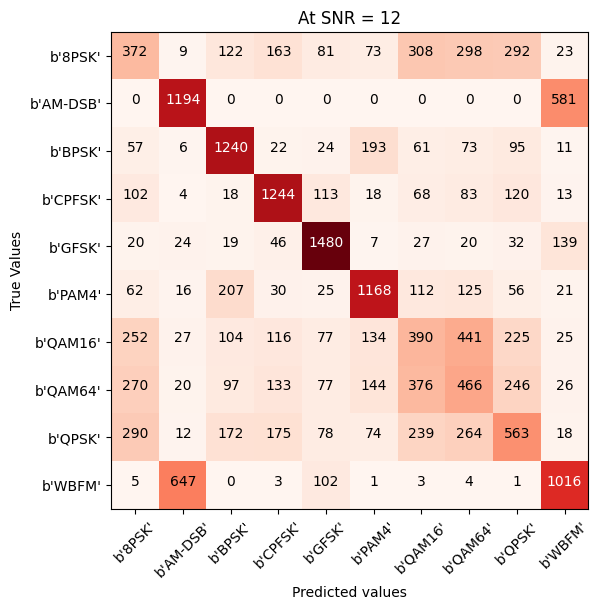

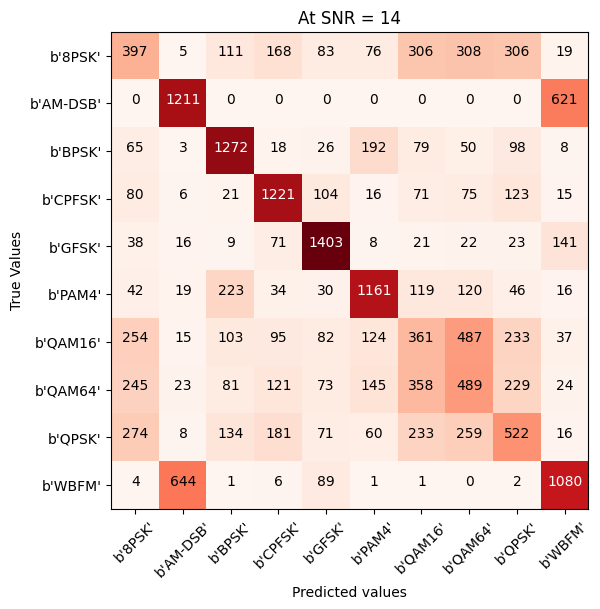

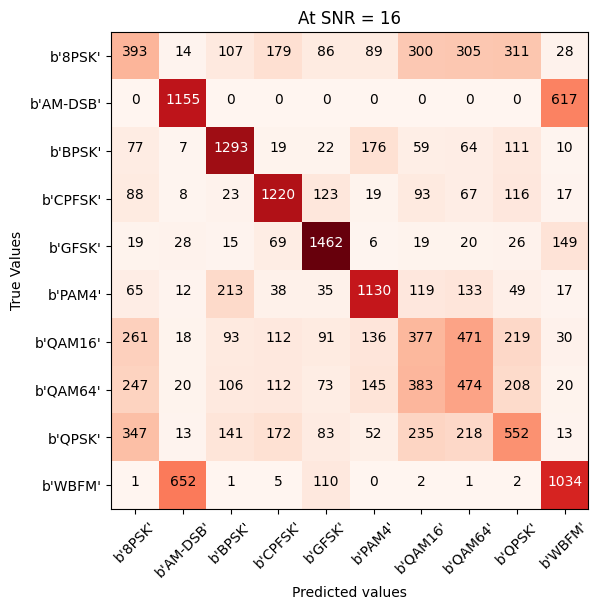

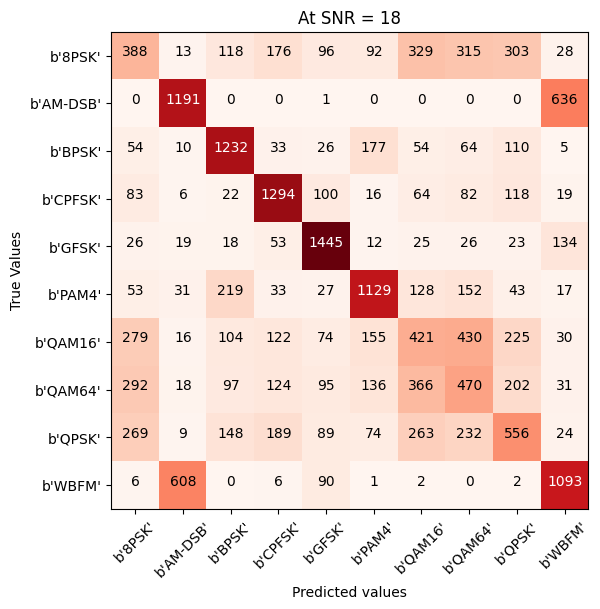

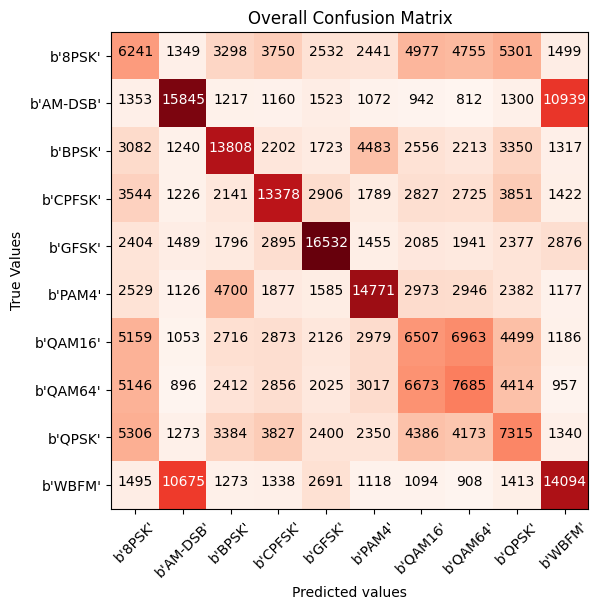

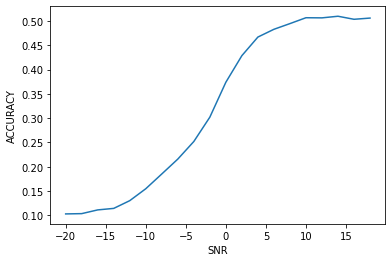

----------------Accuracies for SNRS-------------------
{-20: 0.10293042353338208, -18: 0.1035163750068572, -16: 0.11119050236341652, -14: 0.11429680567879326, -12: 0.13022209727298284, -10: 0.15474533815752853, -8: 0.18516443498235194, -6: 0.21579705328459067, -4: 0.25200222469410455, -2: 0.302134281903068, 0: 0.3740174914203476, 2: 0.42874651810584957, 4: 0.4670213945238887, 6: 0.4829950782502903, 8: 0.4947209653092006, 10: 0.5068072759736637, 12: 0.5065446478092068, 14: 0.509870812594374, 16: 0.503601108033241, 18: 0.5060935441370223}


In [ ]:
accs = Eval_SNR(get_integral_features() , model_loaded)

In [ ]:
print('Accuracy at SNR = 0 : ' + str(accs[0]))
print('Overall Accuracy : ' +str(sum(accs.values()) / len(snrs) ))

Accuracy at SNR = 0 : 0.3740174914203476
Overall Accuracy : 0.32262091865170806


## Random Forest

In [ ]:
modelfile = open(all_models_path + '/Random_Forest_Raw.sav','rb')
model_loaded = pickle.load(modelfile)

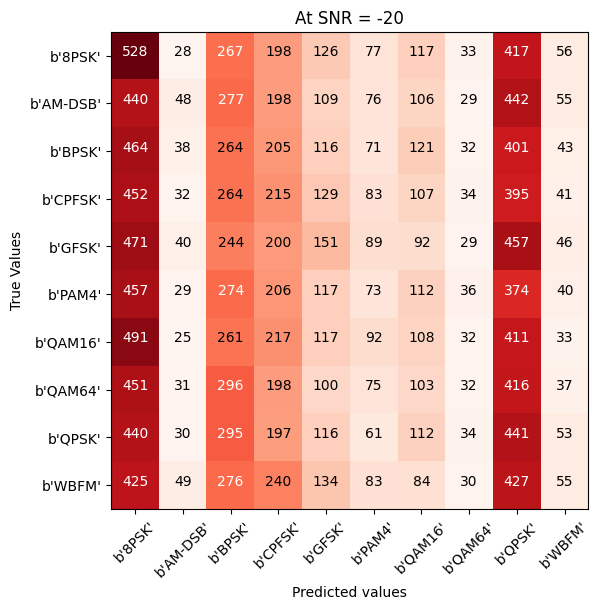

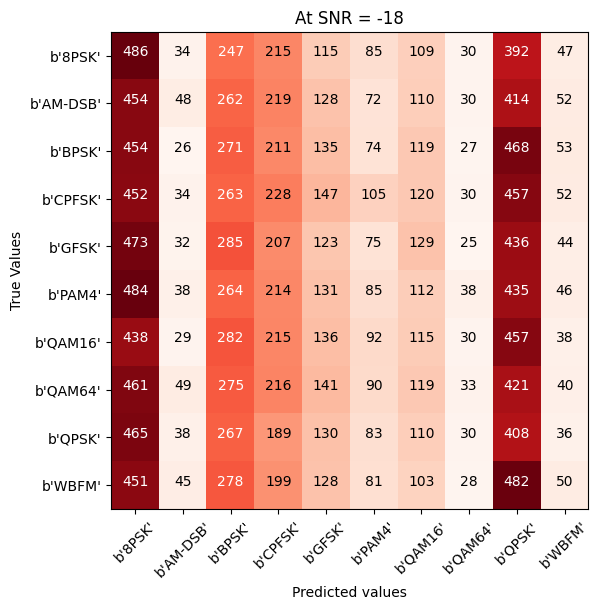

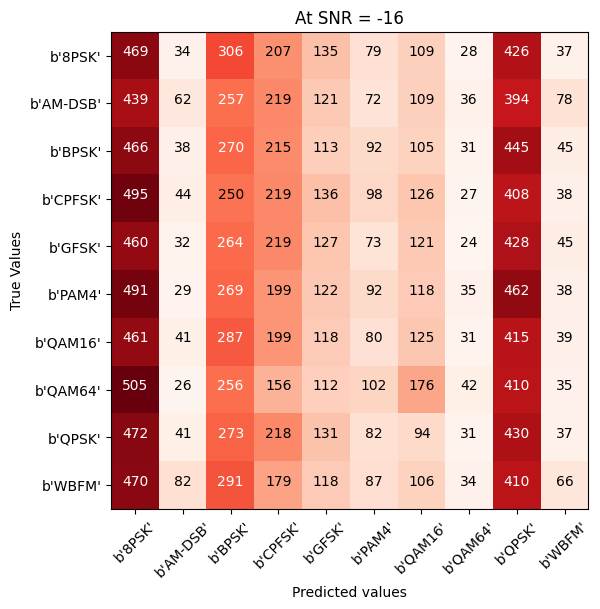

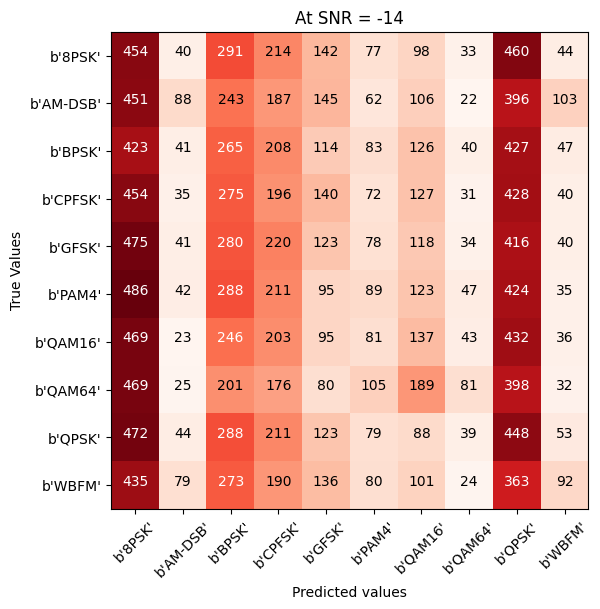

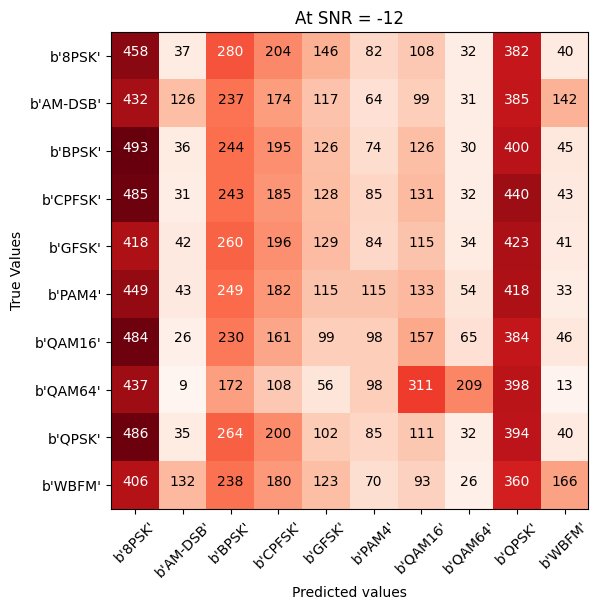

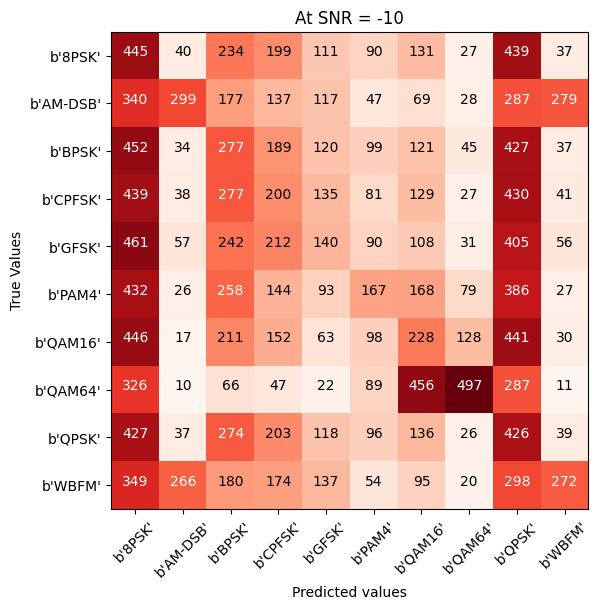

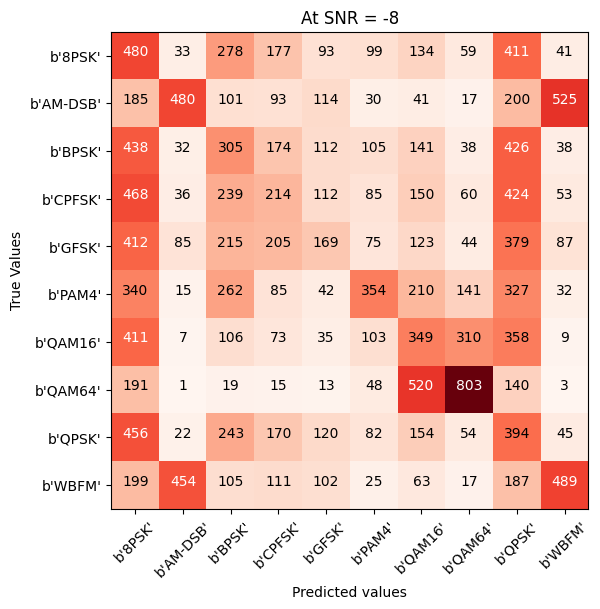

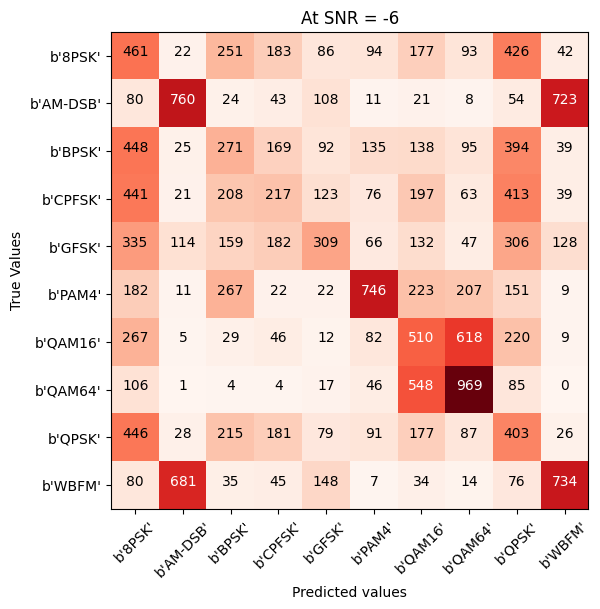

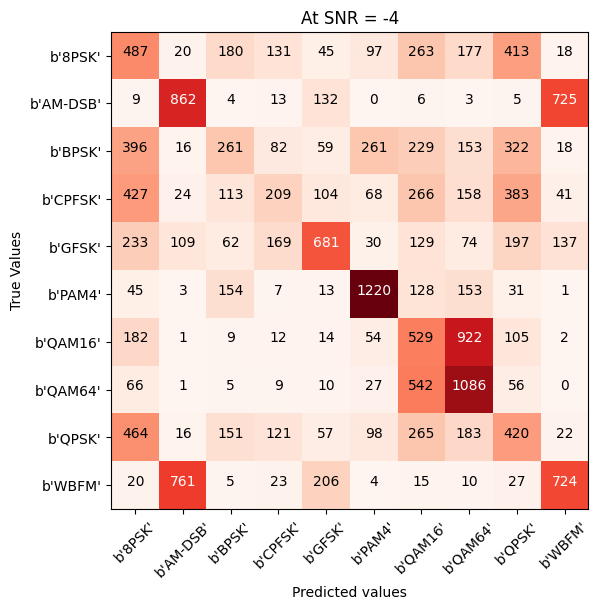

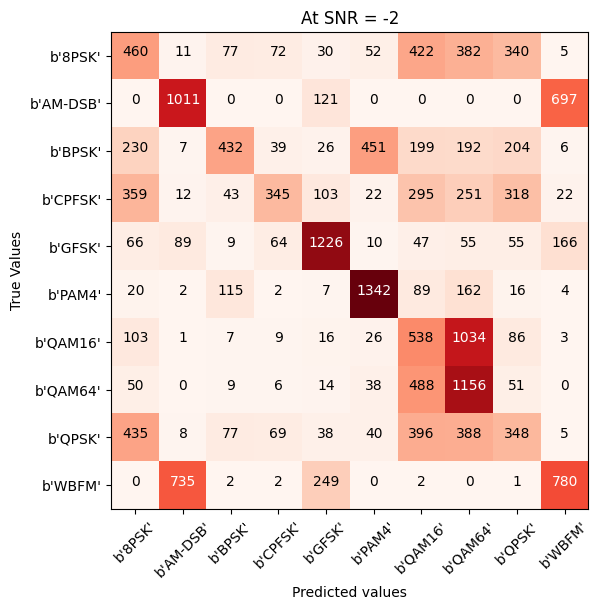

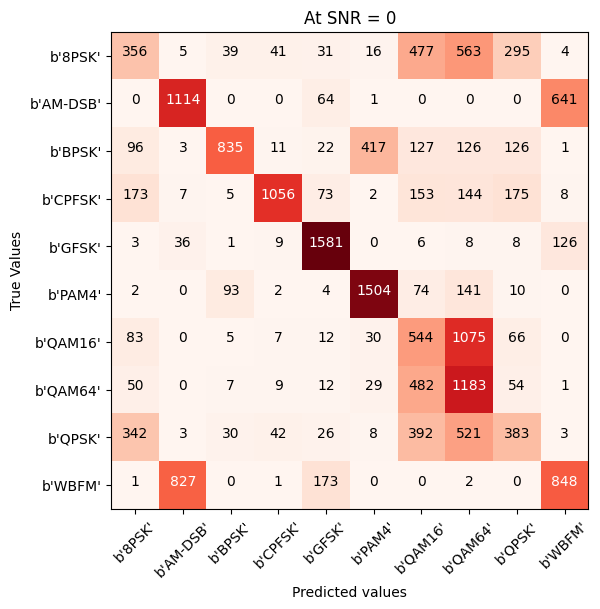

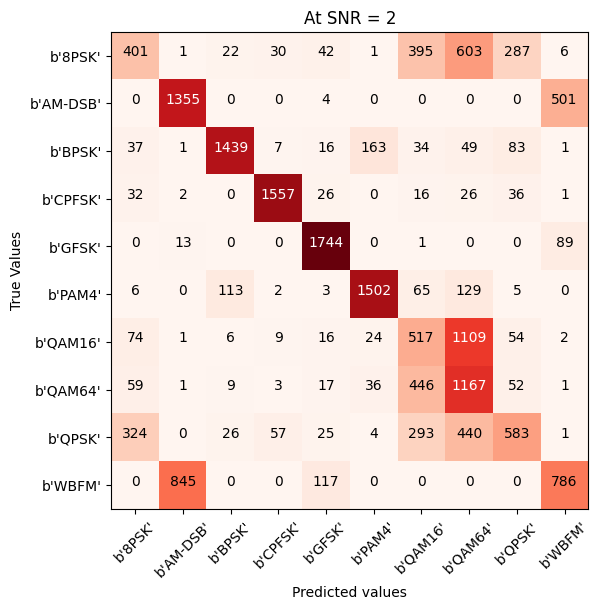

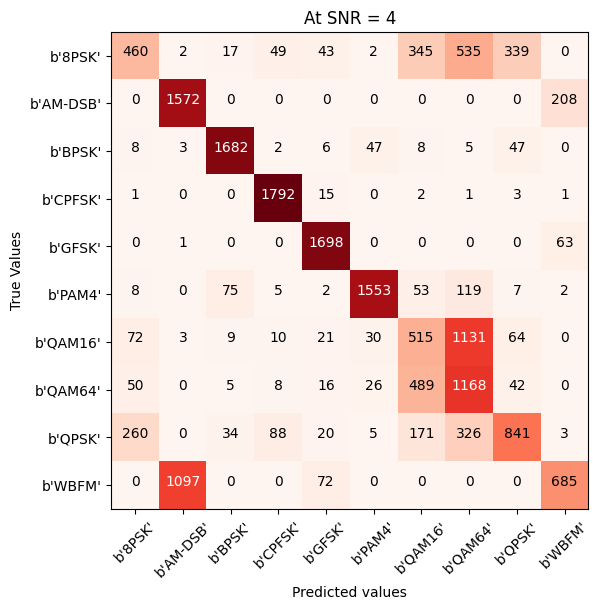

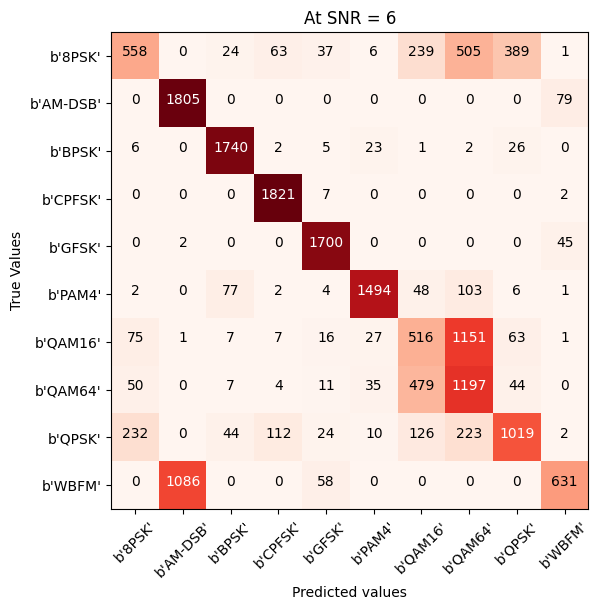

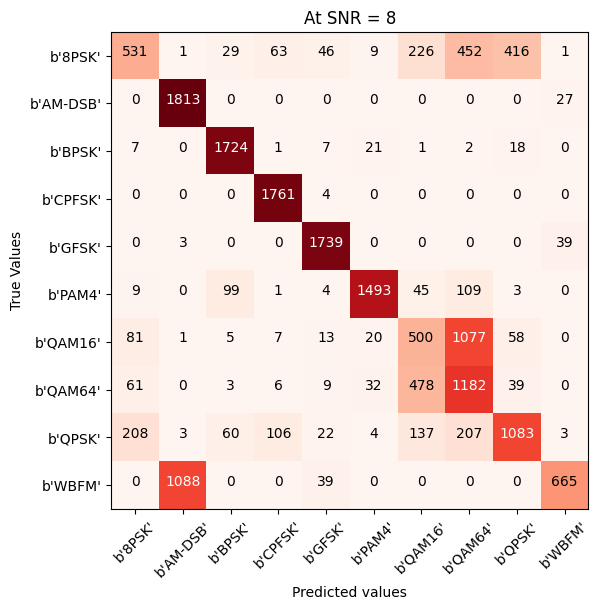

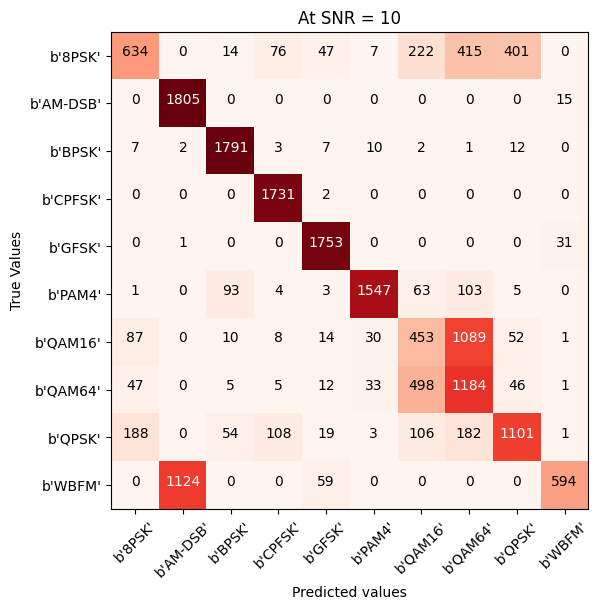

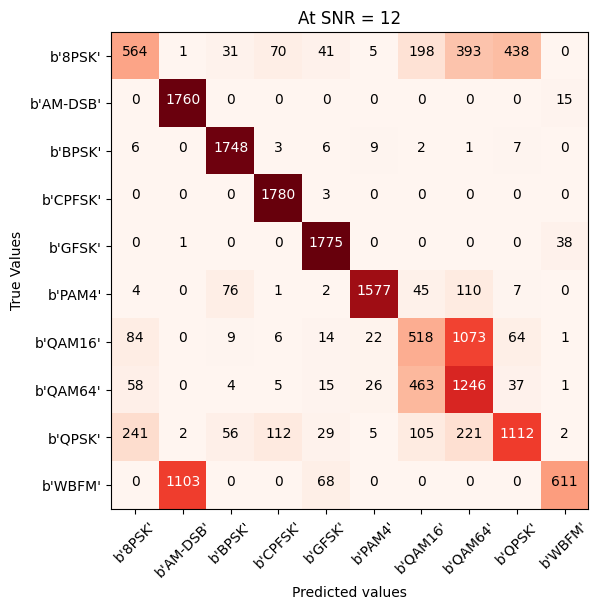

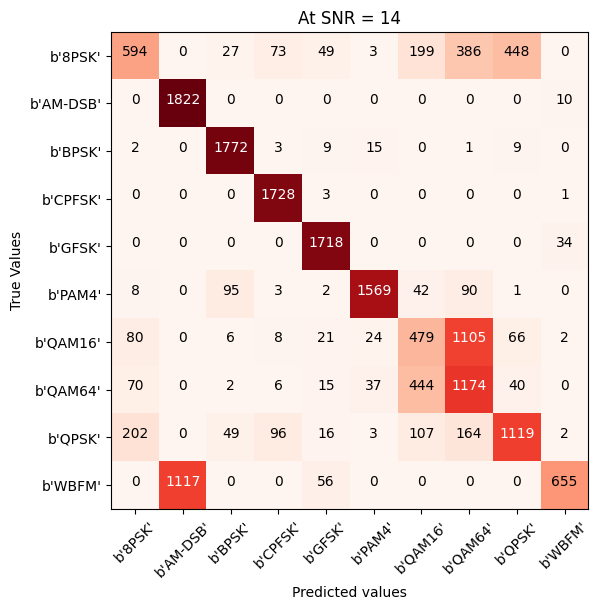

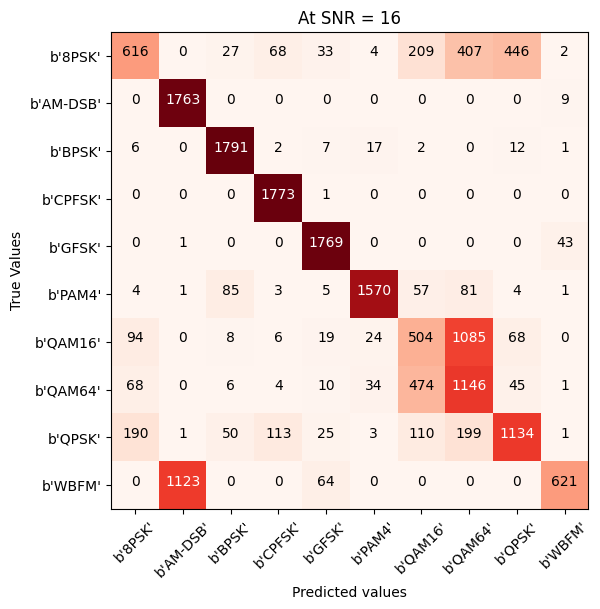

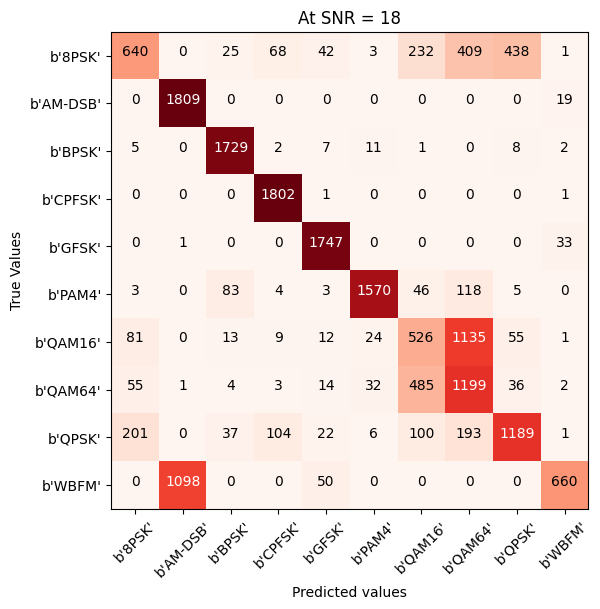

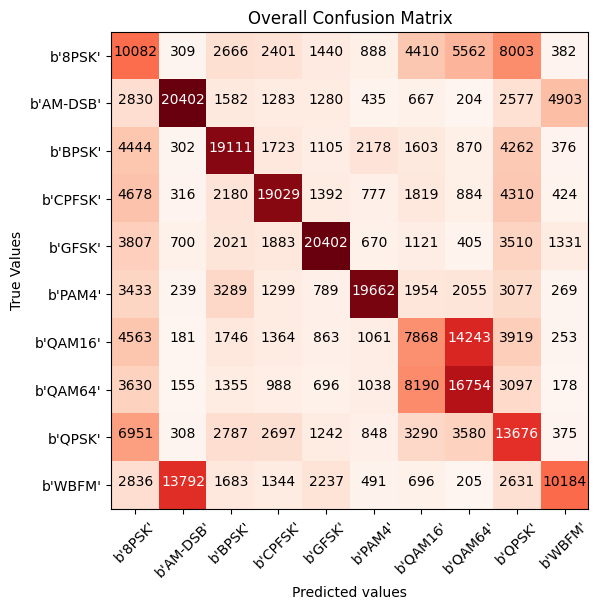

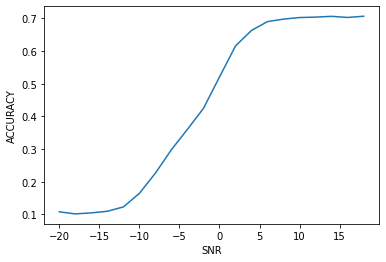

----------------Accuracies for SNRS-------------------
{-20: 0.1077113448450419, -18: 0.10132206923034724, -16: 0.10453995822798724, -14: 0.10941659272404614, -12: 0.12274388529659826, -10: 0.16426384636793764, -8: 0.22617513586195306, -6: 0.2979949041763598, -4: 0.3603448275862069, -2: 0.4245220097821254, 0: 0.5205358131296358, 2: 0.6156545961002785, 4: 0.6632302405498282, 6: 0.690206271083338, 8: 0.6977822468018546, 10: 0.7026559535766097, 12: 0.7038824181919023, 14: 0.7063363346568984, 16: 0.7028808864265927, 18: 0.706576635924462}


In [ ]:
accs = Eval_SNR(X , model_loaded)

In [ ]:
print('Accuracy at SNR = 0 : ' + str(accs[0]))
print('Overall Accuracy : ' +str(sum(accs.values()) / len(snrs) ))

Accuracy at SNR = 0 : 0.5205358131296358
Overall Accuracy : 0.4364387985270001


## ----------------Neural Networks Models---------------------

In [ ]:
import tensorflow as tf
from tensorflow import keras

## Fully Connected Layer

In [ ]:
model_loaded = keras.models.load_model(all_models_path + '/fully_concted_classifier.h5')

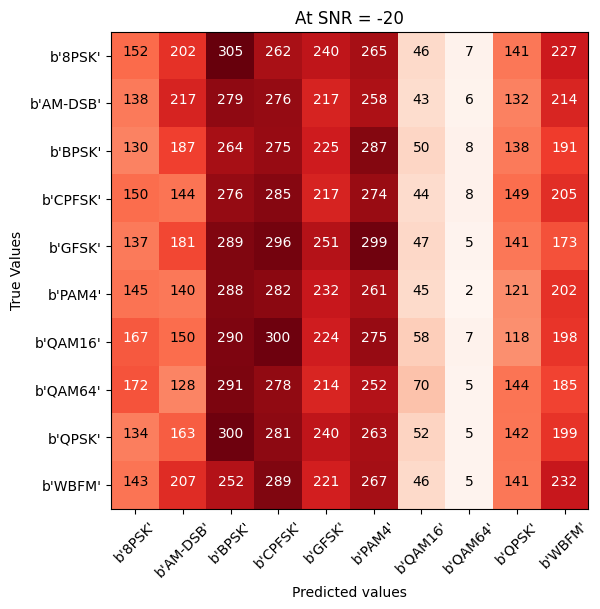

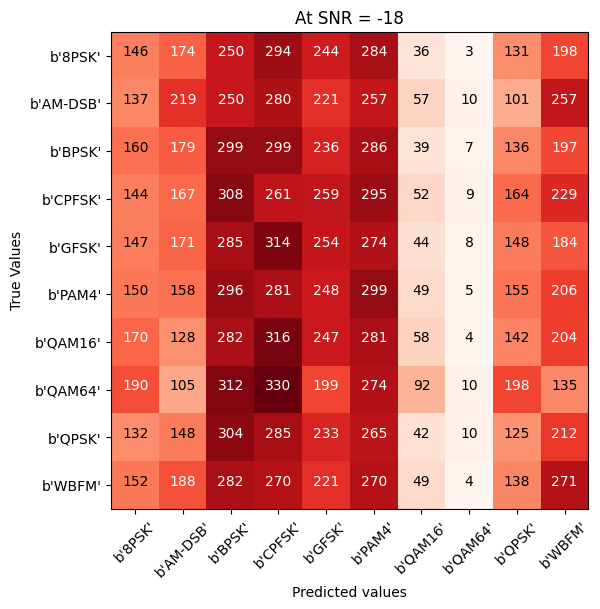

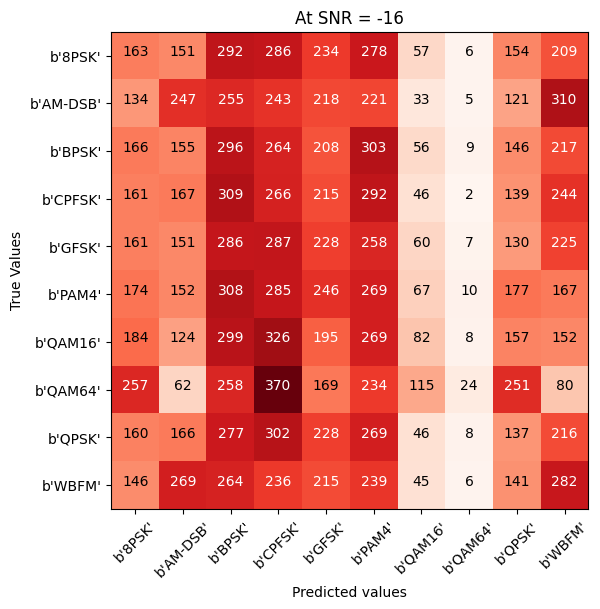

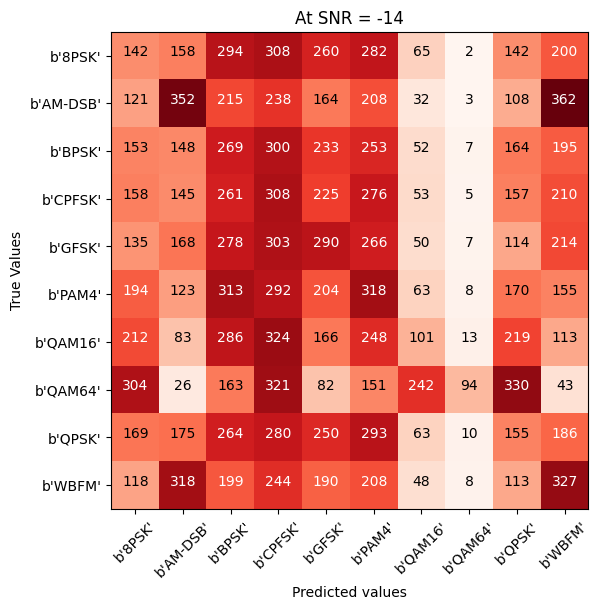

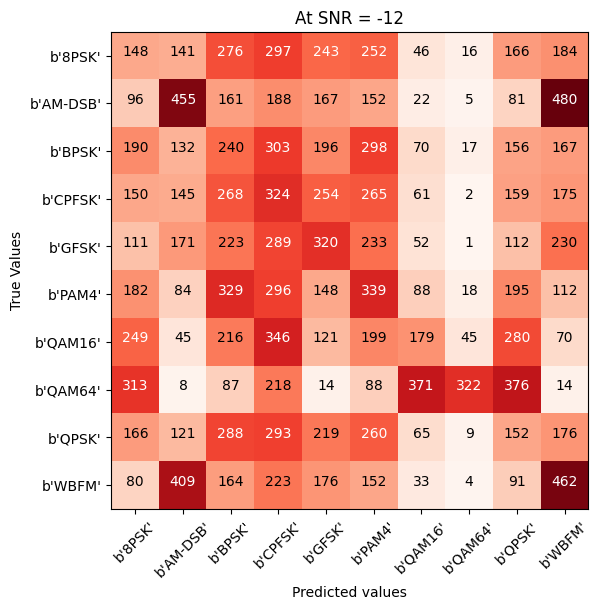

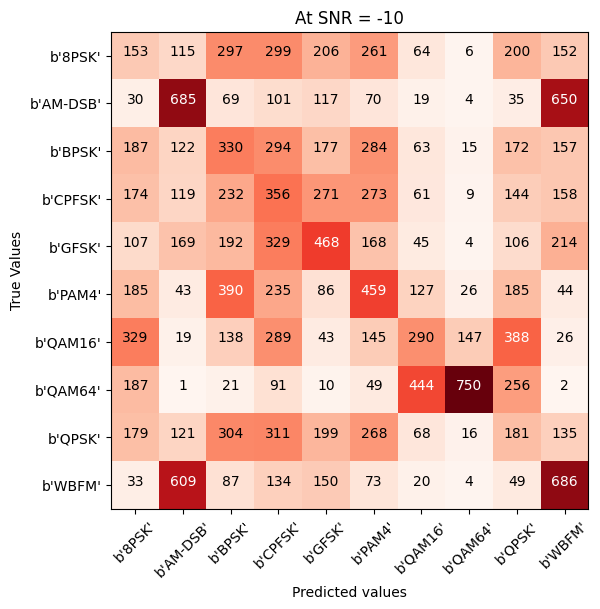

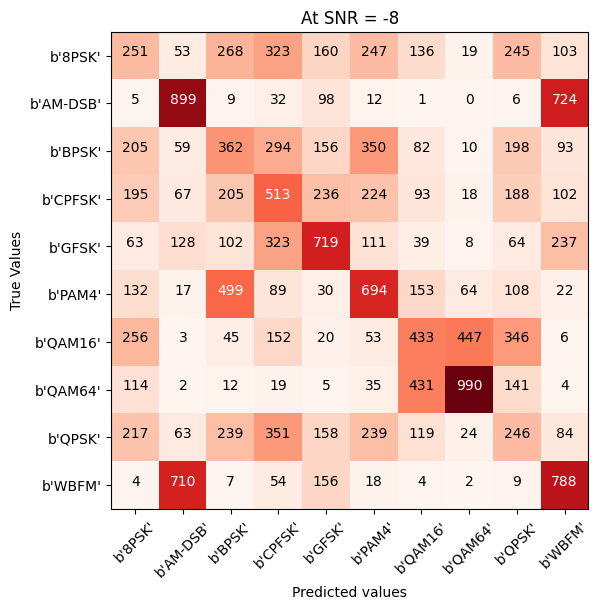

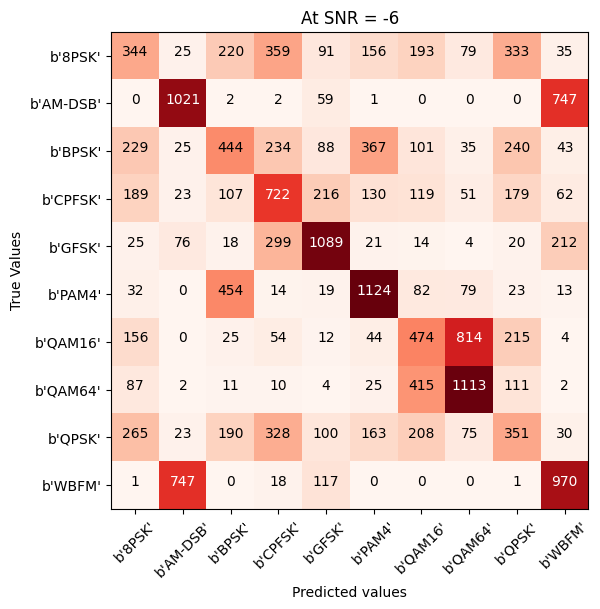

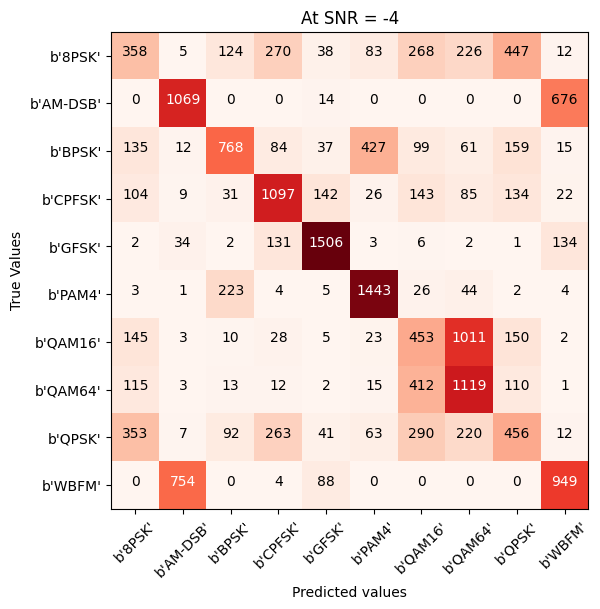

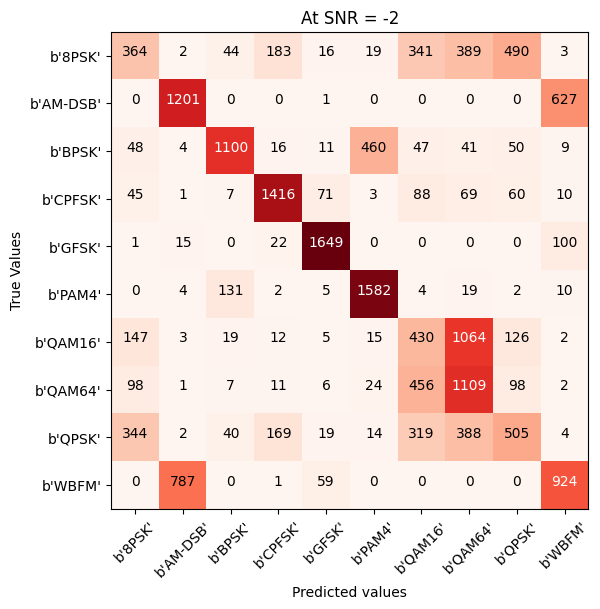

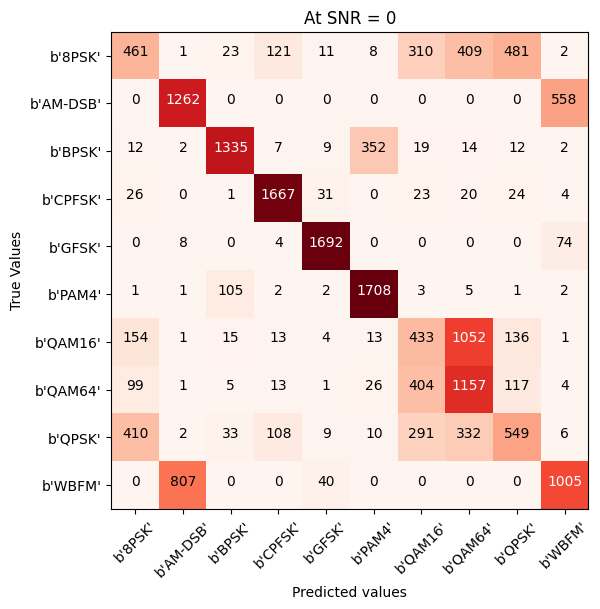

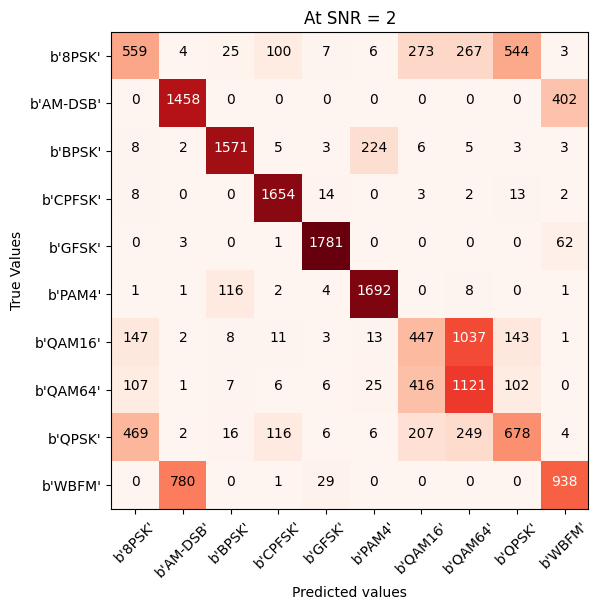

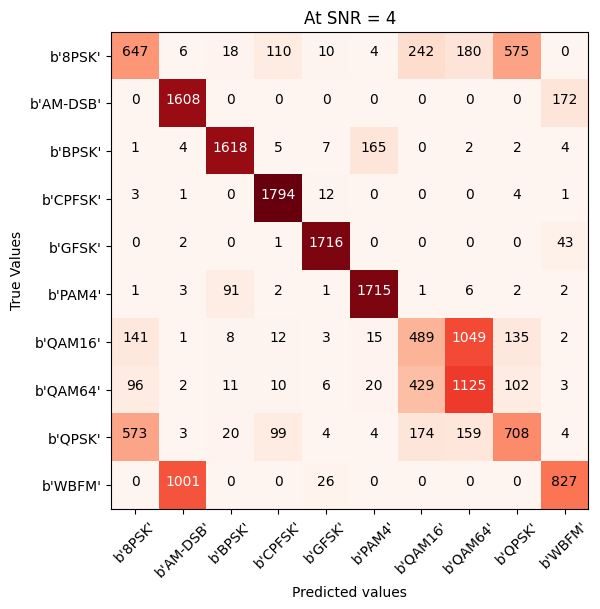

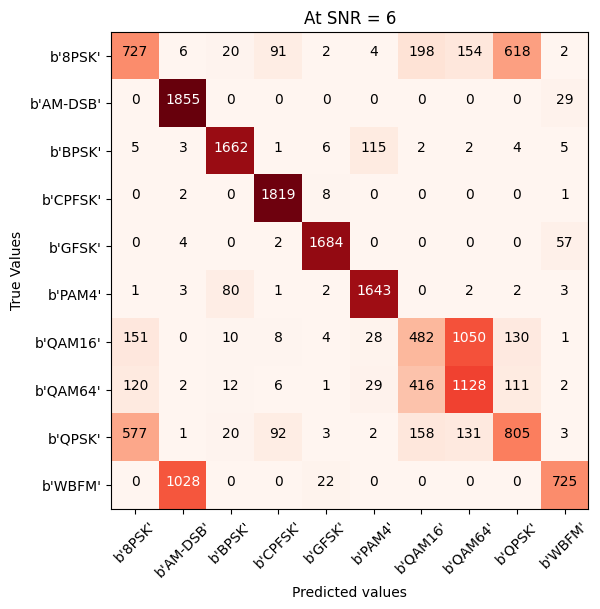

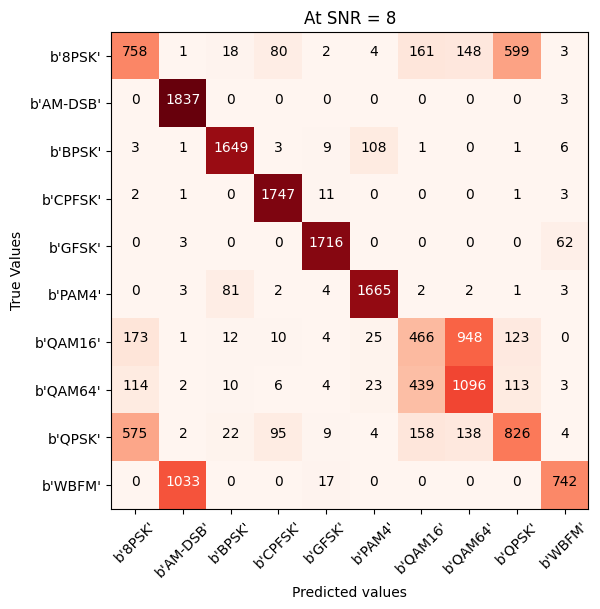

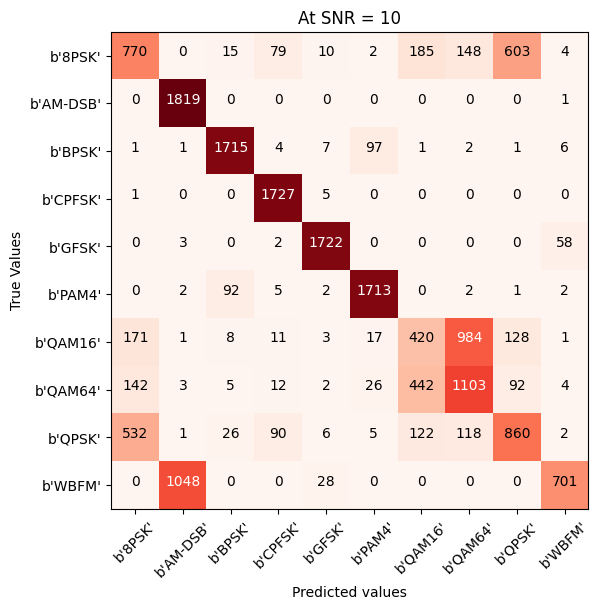

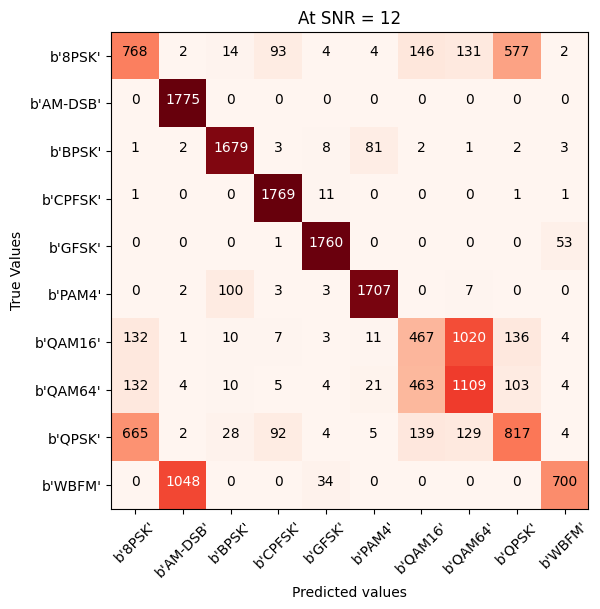

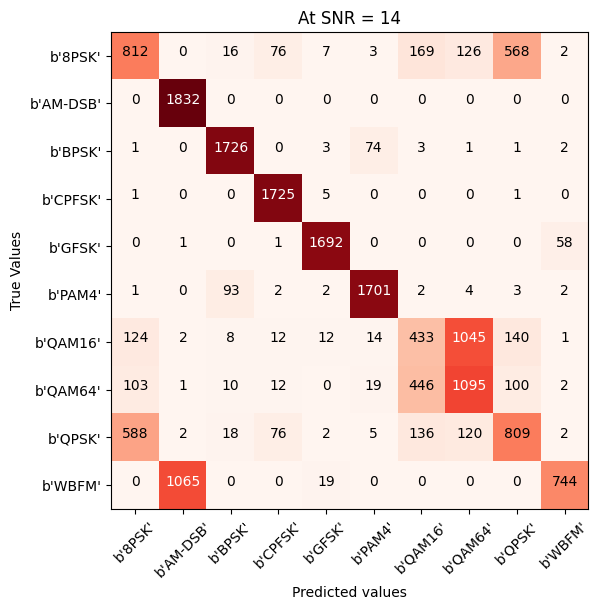

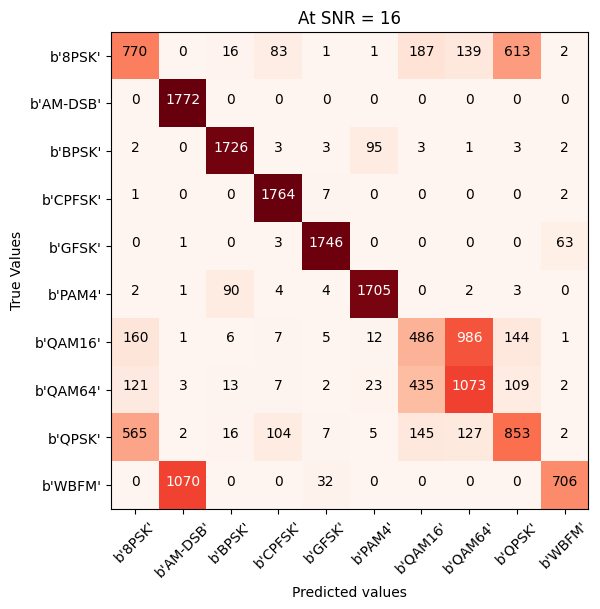

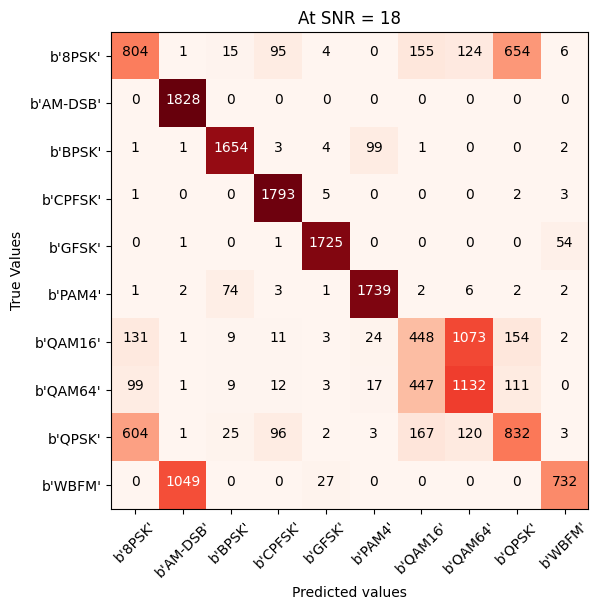

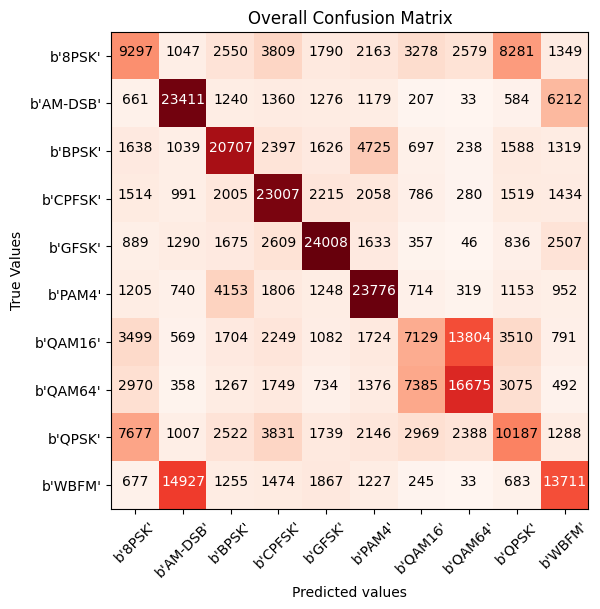

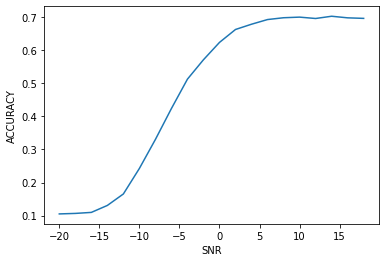

----------------Accuracies for SNRS-------------------
{-20: 0.10501153045728107, -18: 0.1065335454495584, -16: 0.1095965702979004, -14: 0.13065661047027508, -12: 0.16536407084621874, -10: 0.24258279988867243, -8: 0.3302706033951482, -6: 0.4238395923341088, -4: 0.5126807563959955, -2: 0.5713650511338373, 0: 0.6237684047381822, 2: 0.6628969359331476, 4: 0.6788050105309833, 6: 0.6929159984515844, 8: 0.6983967376124239, 10: 0.7002566677826135, 12: 0.6961175818080976, 14: 0.7029248923438286, 16: 0.6981163434903047, 18: 0.6964756258234519}


In [ ]:
accs = Eval_SNR(X , model_loaded , Neural_Net=True)

In [ ]:
print('Accuracy at SNR = 0 : ' + str(accs[0]))
print('Overall Accuracy : ' +str(sum(accs.values()) / len(snrs) ))

Accuracy at SNR = 0 : 0.6237684047381822
Overall Accuracy : 0.47742876645918075


## CNN

In [ ]:
model_loaded = keras.models.load_model(all_models_path + '/CNN_Raw.h5')

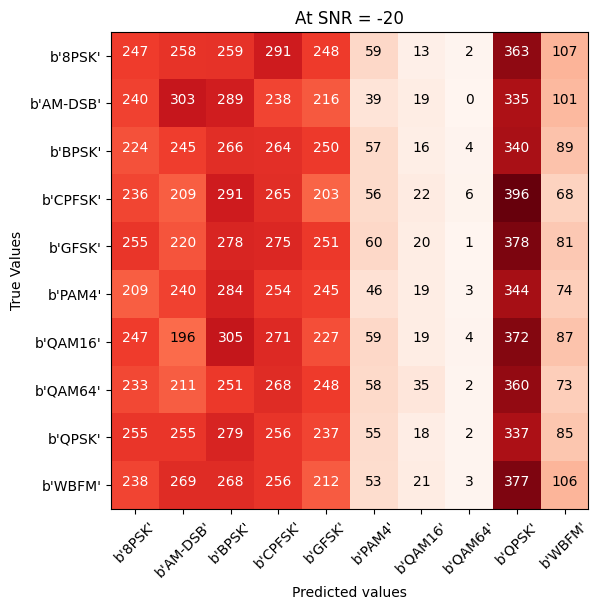

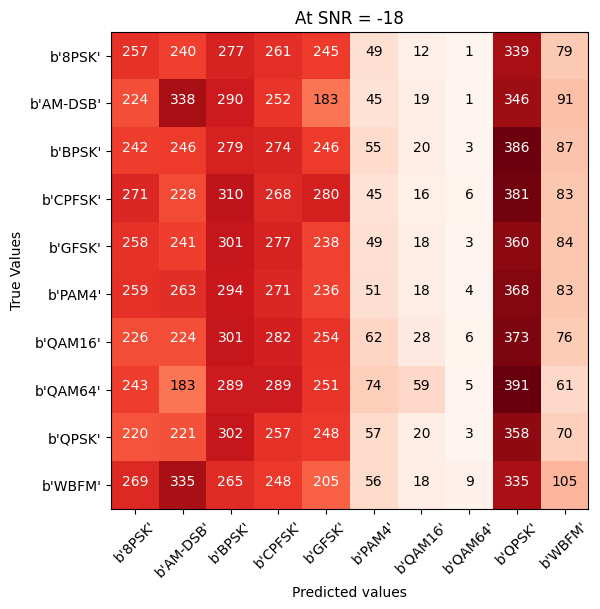

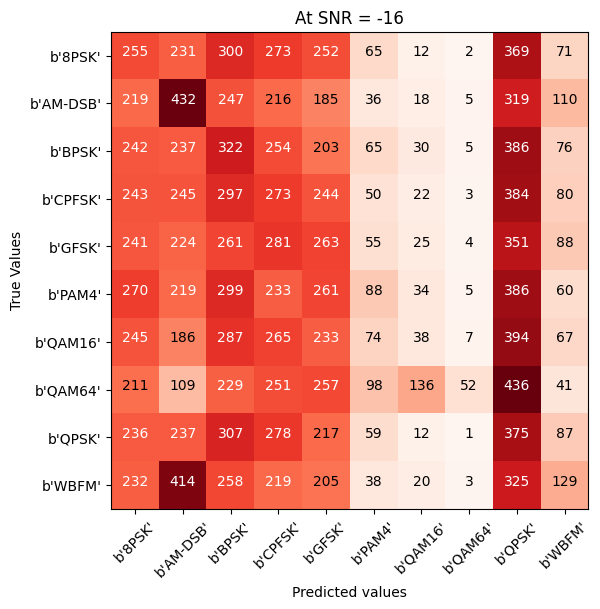

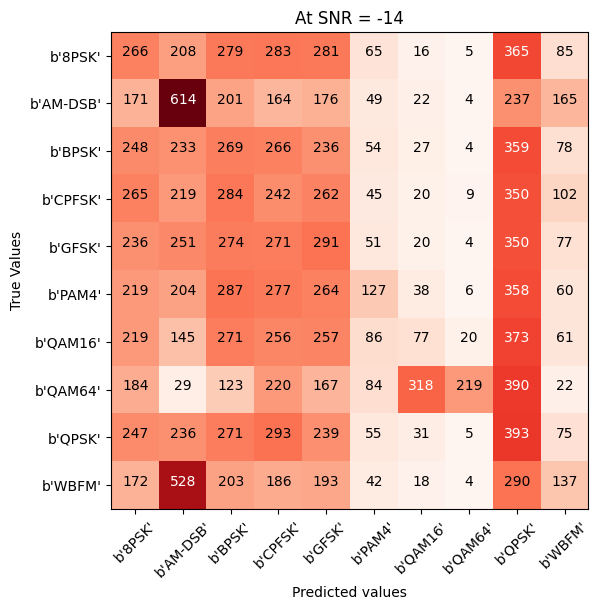

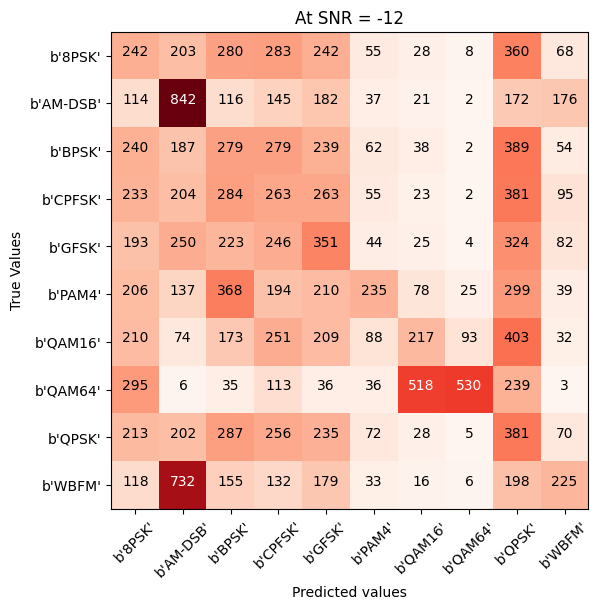

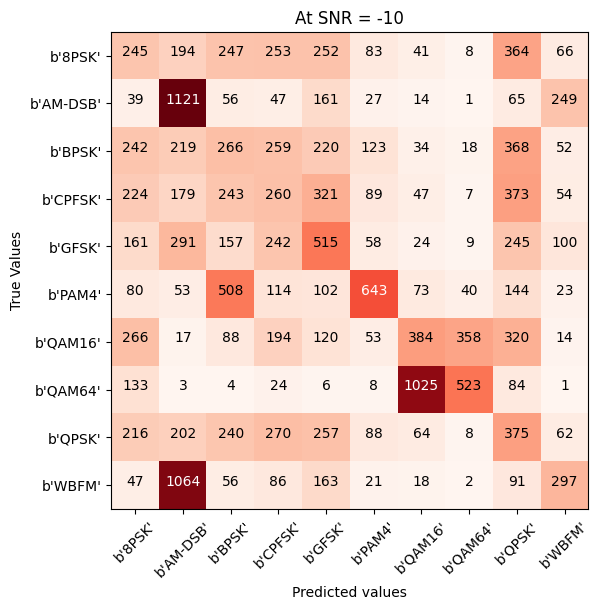

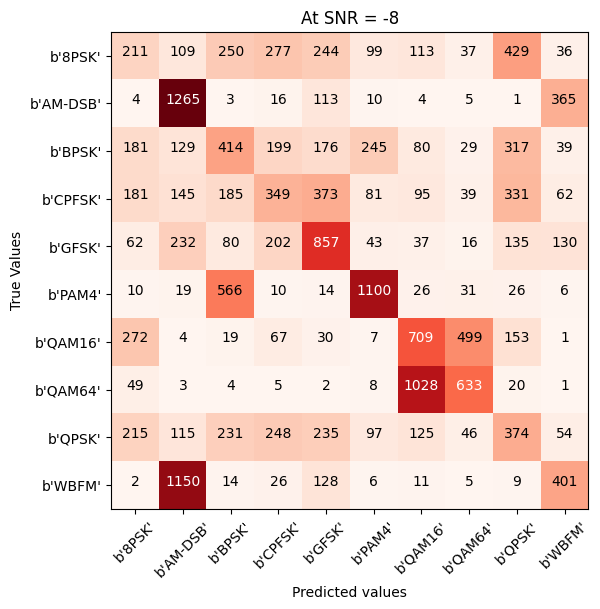

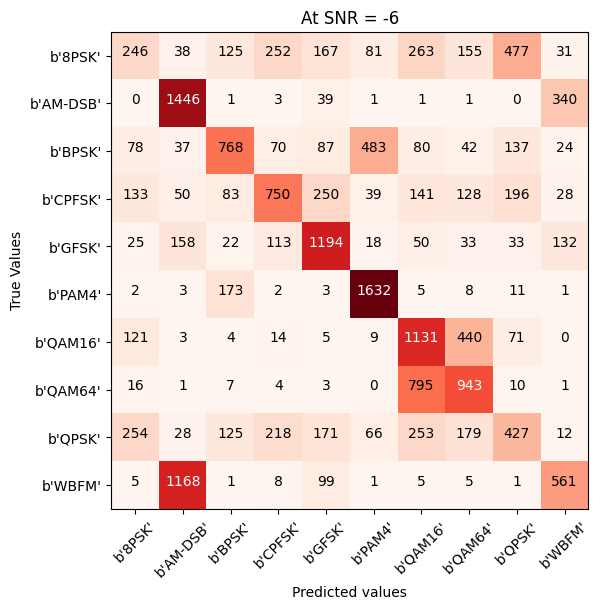

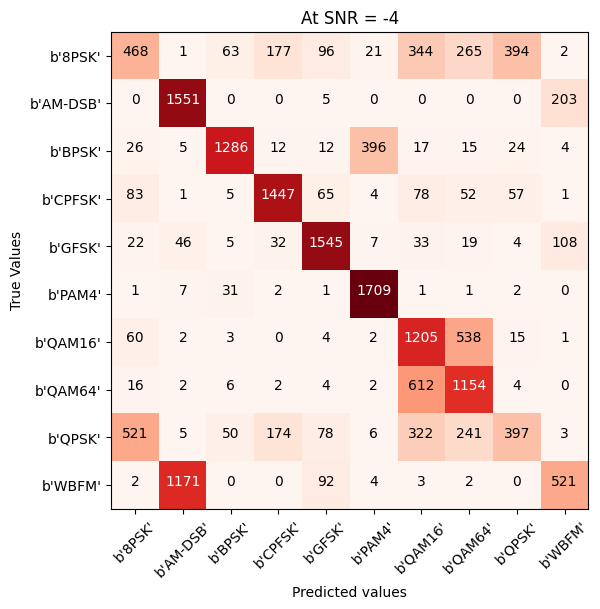

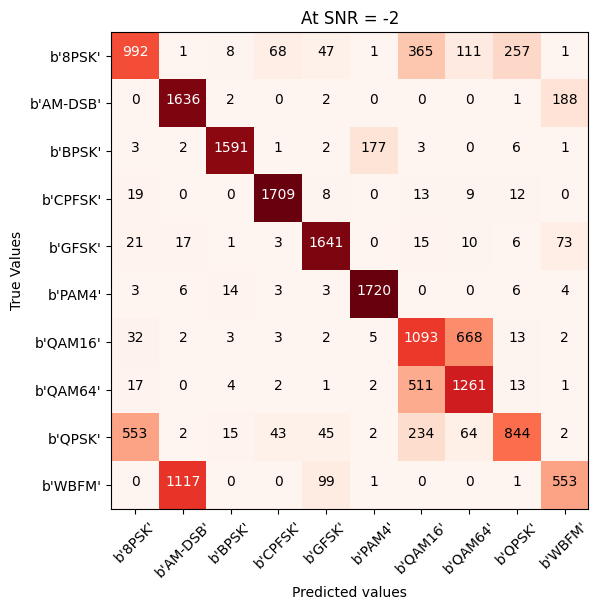

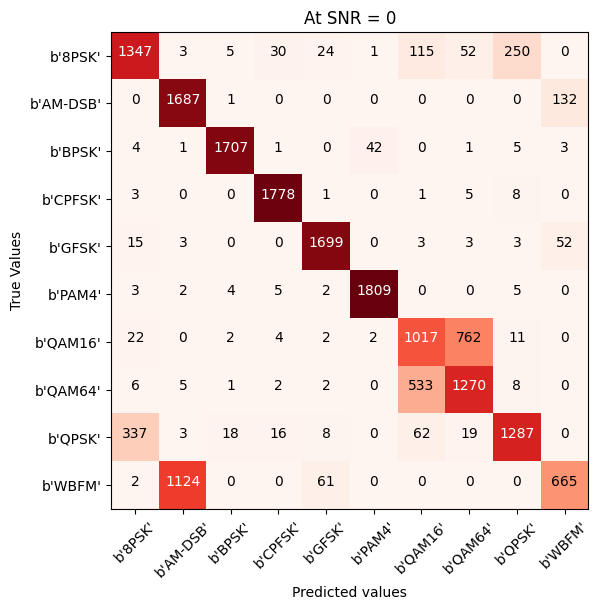

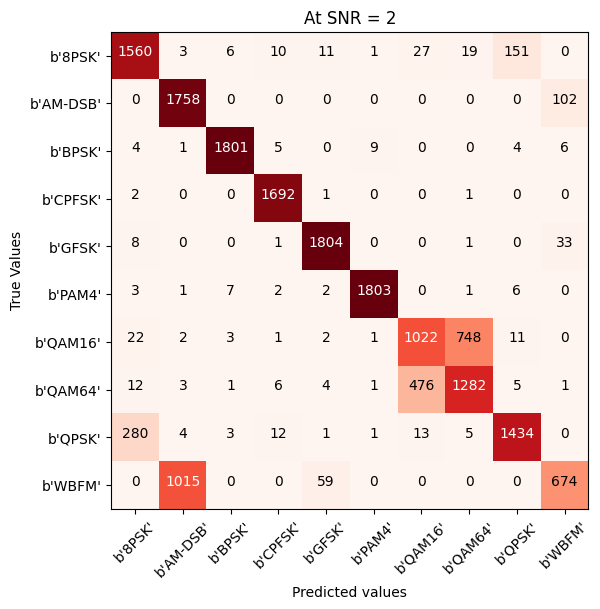

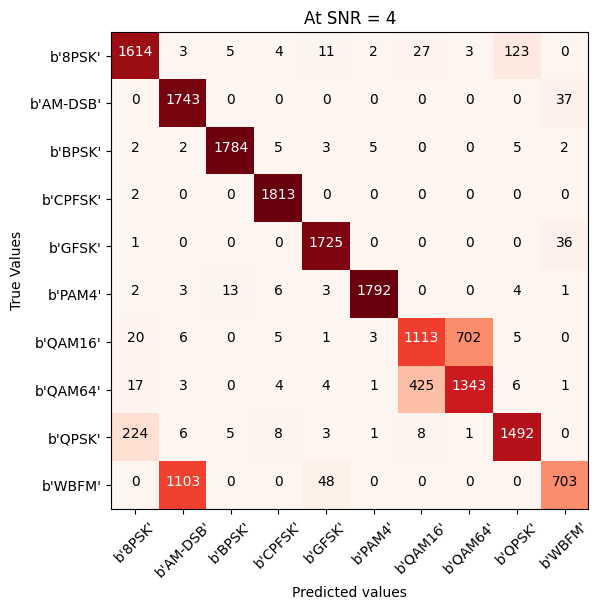

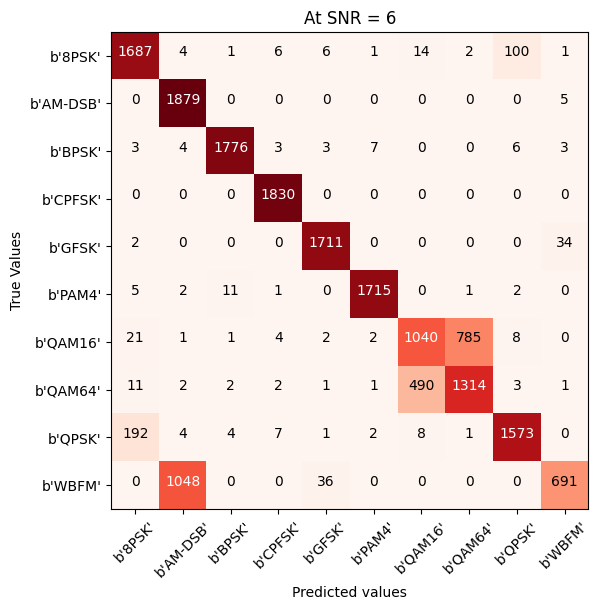

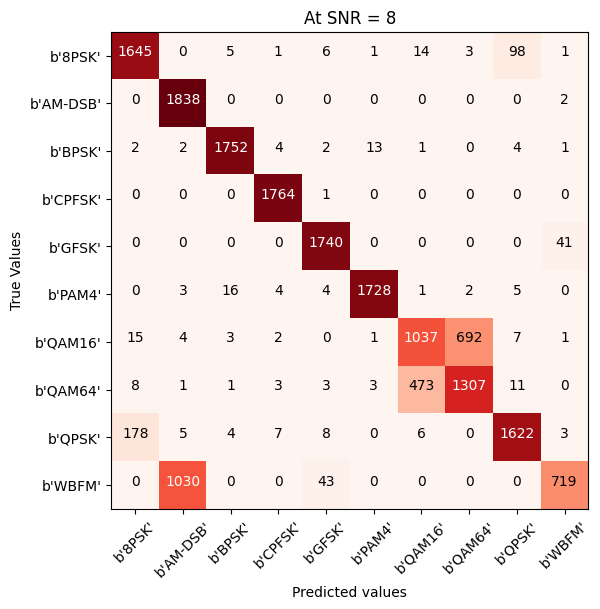

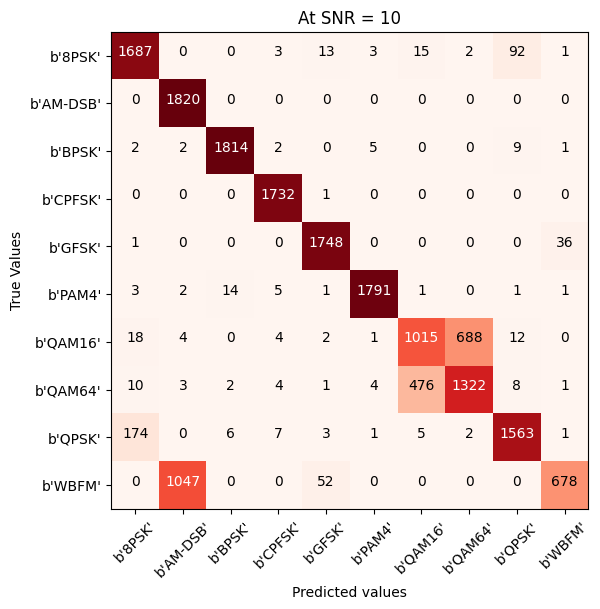

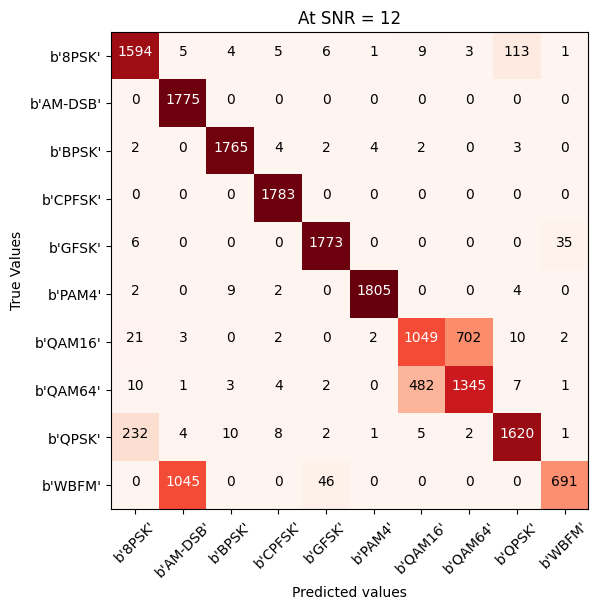

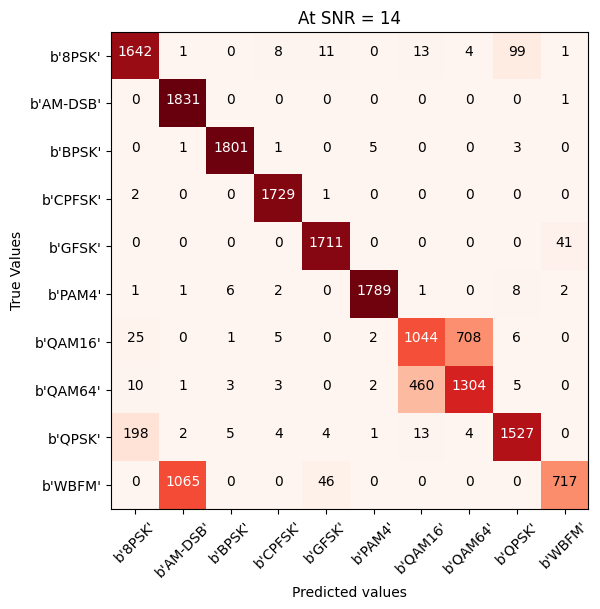

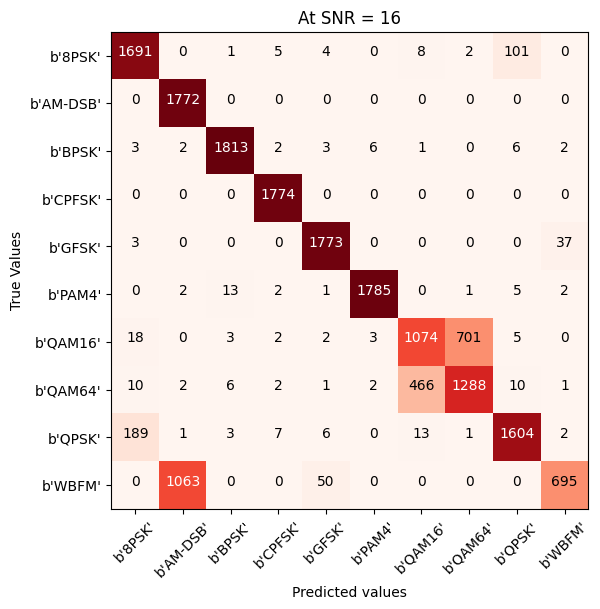

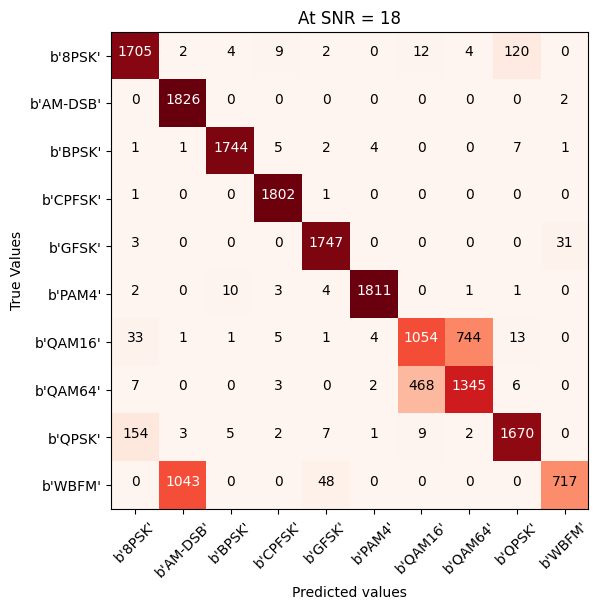

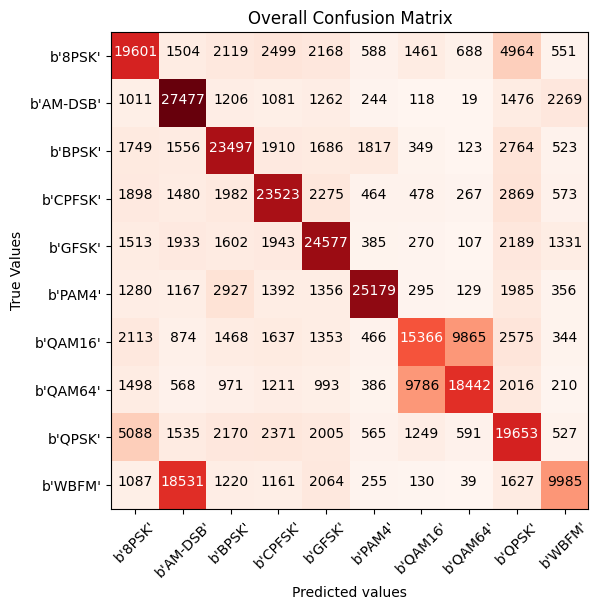

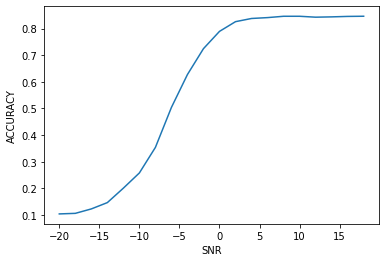

----------------Accuracies for SNRS-------------------
{-20: 0.1036053771303223, -18: 0.10571068078336716, -16: 0.12240298999670221, -14: 0.14612910381543923, -12: 0.2004498172617374, -10: 0.25766768716949623, -8: 0.3536892823127346, -6: 0.5039326465049296, -4: 0.6275305895439377, -2: 0.7247665629168519, 0: 0.7896601350603343, 2: 0.8261838440111421, 4: 0.8381554151424454, 6: 0.8414532986783166, 8: 0.8464331601586503, 10: 0.8464457091842428, 12: 0.8430393788130893, 14: 0.8441921592752083, 16: 0.8459279778393352, 18: 0.8465634606938954}


In [ ]:
accs = Eval_SNR(X , model_loaded , Neural_Net=True)

In [ ]:
print('Accuracy at SNR = 0 : ' + str(accs[0]))
print('Overall Accuracy : ' +str(sum(accs.values()) / len(snrs) ))

Accuracy at SNR = 0 : 0.7896601350603343
Overall Accuracy : 0.5756969638146088
